In [1]:
#https://github.com/omartinsky/HJM/blob/main/hjm.ipynb
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
#import copy as copylib
#from progressbar import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator
#from matplotlib.animation import FuncAnimation
#from matplotlib.widgets import Slider
import scipy
from scipy.optimize import minimize, least_squares
from scipy.interpolate import make_interp_spline, CubicSpline, griddata, bisplrep, bisplev, PchipInterpolator, Akima1DInterpolator
from scipy.integrate import quad, dblquad, tplquad, nquad
from scipy.stats import norm
from scipy import integrate
import math
import time as time
import datetime as datetime
#from datetime import timedelta
#%pylab

#pylab.rcParams['figure.figsize']=(16,4.5)
np.random.seed(0)

In [14]:
plt.rcParams.update({
    'text.usetex' : True,
    "font.family": "Times New Roman",
    "font.monospace": 'Computer Modern',
    "font.size":18.5,
    "axes.labelsize":22.5
})
plt.rcParams['lines.linewidth']=1
plt.rcParams['figure.figsize'] = (10, 6)

The dataframe we load contains Zero Rates from the daily EUR 6M curve (i.e. the rates correspond to sets of 6m loans) starting from Januari 2 2006, untill April 10 2023. The columns are labeled by the tenors of the corresponding ZCB, while the rows correspond to the number of days that passed since Jan 02 2006. Hence the element on the i-th row and j-th column corresponds to a zero rate at i days for a ZCB with maturity at i+j.

One can construct discount factors from this by

$$D(t,T)=[1+ZR(t,T)]^{-T},$$

where $t$ denotes the day (we will set 02/01/2006 equal to time $t=0$ and 10/04/2023 equal to time $t=4484$; note that this is in number of days and we will need to convert this to "trading" years).

The discount factors can in turn be used to calculate forward rates 

$$F(t;T_i,T_{i+1})=\frac{-\ln\left(\frac{D(t,T_{i+1})}{D(t,T_i)}\right)}{T_{i+1}-T_i}.$$

These denote the rate on a loan between time $T_i$ and $T_{i+1}$.
Note that this means that we will have a matrix of forward rates with one less column.

Furthermore, it is important to note that the FORWARD RATE $F(t;T_i,T_{i+1})$ is __NOT__ the instantaneous forward rate $f(t,T)$. However, we can get the instantaneous forward rate $f(t,T)$ when we let $T_{i+1}-T_i\rightarrow 0$, or, in other words

$$f(t,T)=\lim_{T_i\rightarrow T_{i+1}} F(t;T_i,T_{i+1}) $$
$$f(t,T)=-\frac{\partial}{\partial T}\ln D(t,T)$$

The question is now, should we interpolate between the tenors to obtain a forward rate $F(t;T,T+\epsilon)$ for every tenor $T$, where $\epsilon$ is 1 trading day such that we can fairly accurately approximate the instantaneous forward rate as 

$$f(t,T)=F(t;T,T+\epsilon)$$

In [3]:
dataframe = pd.read_excel(r'Copy_of_CUBE_Rates.xlsx', engine='openpyxl')
pd.options.display.max_rows = 10
display(dataframe)

IR_Underlying         6M EUR Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                  NaN            NaN        NaN        NaN        NaN   
1     Value Timeseries  Column Labels        NaN        NaN        NaN   
2           Row Labels             1D         7D         1M         2M   
3             20060102       0.064836    0.06373   0.053594   0.043991   
4             20060103       0.064963   0.063855   0.053699   0.044077   
...                ...            ...        ...        ...        ...   
4511          20230517       0.033399   0.033407    0.03373   0.034687   
4512          20230518       0.031724   0.031727   0.032272   0.034054   
4513          20230519       0.032812   0.032814   0.033238   0.034648   
4514          20230522       0.033144   0.033156    0.03361   0.034939   
4515          20230523       0.033419    0.03343   0.033872   0.035141   

     Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 29  \
0           NaN        NaN        NaN        NaN        NaN  ...         NaN   
1           NaN        NaN        NaN        NaN        NaN  ...         NaN   
2            3M         4M         5M         6M         7M  ...         15Y   
3      0.037594   0.033458   0.030595   0.028139   0.028096  ...    0.037867   
4      0.037668   0.033523   0.030655   0.028195   0.028142  ...    0.037936   
...         ...        ...        ...        ...        ...  ...         ...   
4511   0.035532   0.036238   0.037122   0.037445    0.03785  ...    0.030149   
4512   0.035225    0.03607   0.037096   0.037489    0.03803  ...     0.03109   
4513   0.035668    0.03642   0.037352   0.037721   0.038241  ...     0.03132   
4514   0.035878   0.036626   0.037542   0.037889   0.038359  ...    0.031104   
4515   0.036072   0.036842   0.037697   0.038041   0.038509  ...    0.031465   

     Unnamed: 30 Unnamed: 31 Unnamed: 32 Unnamed: 33 Unnamed: 34 Unnamed: 35  \
0            NaN         NaN         NaN         NaN         NaN         NaN   
1            NaN         NaN         NaN         NaN         NaN         NaN   
2            16Y         17Y         18Y         19Y         20Y         25Y   
3       0.038102    0.038336    0.038571    0.038805     0.03904    0.039264   
4       0.038168      0.0384    0.038632    0.038864    0.039096    0.039503   
...          ...         ...         ...         ...         ...         ...   
4511    0.030038    0.029862    0.029543    0.029276    0.028917    0.027221   
4512    0.030968    0.030723     0.03051    0.030179    0.029802    0.028002   
4513    0.031147    0.030946    0.030592    0.030206    0.029891    0.027959   
4514    0.030945    0.030717      0.0304    0.030098     0.02974    0.027871   
4515    0.031329    0.031115     0.03068    0.030387    0.029947    0.028174   

     Unnamed: 36 Unnamed: 37 Unnamed: 38  
0            NaN         NaN         NaN  
1            NaN         NaN         NaN  
2            30Y         40Y         50Y  
3       0.039411    0.040435    0.041073  
4       0.039482    0.040527     0.04118  
...          ...         ...         ...  
4511    0.025628    0.023334    0.021336  
4512    0.026456    0.023979    0.022075  
4513    0.026302    0.023761    0.021779  
4514    0.026242    0.023801    0.021783  
4515    0.026508    0.024023    0.021825  

[4516 rows x 39 columns]

In [4]:
#Remove unwanted rows
df = dataframe[2:dataframe.shape[0]]
#Rename Columns
df.columns = [str(i) for i in range(df.shape[1])]
df = df.rename(columns = {str(i) : str(df.iloc[0][i]) for i in range(df.shape[1])})
#Remove the row with column names
df = df[1:dataframe.shape[0]]
display(df)

Row Labels        1D        7D        1M        2M        3M        4M  \
3      20060102  0.064836   0.06373  0.053594  0.043991  0.037594  0.033458   
4      20060103  0.064963  0.063855  0.053699  0.044077  0.037668  0.033523   
5      20060104  0.064606  0.063503  0.053404  0.043835  0.037461  0.033339   
6      20060105   0.06406  0.062967  0.052952  0.043464  0.037144  0.033057   
7      20060106  0.064256  0.063159  0.053114  0.043597  0.037258  0.033158   
...         ...       ...       ...       ...       ...       ...       ...   
4511   20230517  0.033399  0.033407   0.03373  0.034687  0.035532  0.036238   
4512   20230518  0.031724  0.031727  0.032272  0.034054  0.035225   0.03607   
4513   20230519  0.032812  0.032814  0.033238  0.034648  0.035668   0.03642   
4514   20230522  0.033144  0.033156   0.03361  0.034939  0.035878  0.036626   
4515   20230523  0.033419   0.03343  0.033872  0.035141  0.036072  0.036842   

            5M        6M        7M  ...       15Y       16Y       17Y  \
3     0.030595  0.028139  0.028096  ...  0.037867  0.038102  0.038336   
4     0.030655  0.028195  0.028142  ...  0.037936  0.038168    0.0384   
5     0.030486  0.028039  0.027882  ...   0.03755  0.037782  0.038014   
6     0.030228  0.027802  0.027681  ...  0.037256  0.037497  0.037738   
7     0.030321  0.027888  0.027708  ...  0.037219  0.037447  0.037675   
...        ...       ...       ...  ...       ...       ...       ...   
4511  0.037122  0.037445   0.03785  ...  0.030149  0.030038  0.029862   
4512  0.037096  0.037489   0.03803  ...   0.03109  0.030968  0.030723   
4513  0.037352  0.037721  0.038241  ...   0.03132  0.031147  0.030946   
4514  0.037542  0.037889  0.038359  ...  0.031104  0.030945  0.030717   
4515  0.037697  0.038041  0.038509  ...  0.031465  0.031329  0.031115   

           18Y       19Y       20Y       25Y       30Y       40Y       50Y  
3     0.038571  0.038805   0.03904  0.039264  0.039411  0.040435  0.041073  
4     0.038632  0.038864  0.039096  0.039503  0.039482  0.040527   0.04118  
5     0.038246  0.038477  0.038709  0.039225  0.039271  0.040202  0.040767  
6     0.037979   0.03822  0.038461  0.038898  0.038888  0.039911   0.04058  
7     0.037903  0.038132   0.03836   0.03877  0.038765  0.039763  0.040406  
...        ...       ...       ...       ...       ...       ...       ...  
4511  0.029543  0.029276  0.028917  0.027221  0.025628  0.023334  0.021336  
4512   0.03051  0.030179  0.029802  0.028002  0.026456  0.023979  0.022075  
4513  0.030592  0.030206  0.029891  0.027959  0.026302  0.023761  0.021779  
4514    0.0304  0.030098   0.02974  0.027871  0.026242  0.023801  0.021783  
4515   0.03068  0.030387  0.029947  0.028174  0.026508  0.024023  0.021825  

[4513 rows x 39 columns]

In [5]:
#Get the daycount; Use ACT/365 convention
tradeyear = 365
hist_timeline = list(df.index-3)
#print(hist_timeline)
time_in_years = [t/tradeyear for t in hist_timeline]
#Get the tenors in STRING FORMAT
tenors = [x for x in df.columns[1:df.shape[1]]]
#Get the zero rates
hist_zerorates_dataframe = df[0:][[x for x in df.columns[1:]]]
display(hist_zerorates_dataframe)
hist_zerorates = np.matrix(hist_zerorates_dataframe, dtype=float)
#We want tenors in years
for i,T in enumerate(tenors):
    if len(T)>3:
        tenors[i] = str(int(T[0])*12+int(T[2]))+'M'
print(tenors)
display(hist_zerorates,len(time_in_years))

1D        7D        1M        2M        3M        4M        5M  \
3     0.064836   0.06373  0.053594  0.043991  0.037594  0.033458  0.030595   
4     0.064963  0.063855  0.053699  0.044077  0.037668  0.033523  0.030655   
5     0.064606  0.063503  0.053404  0.043835  0.037461  0.033339  0.030486   
6      0.06406  0.062967  0.052952  0.043464  0.037144  0.033057  0.030228   
7     0.064256  0.063159  0.053114  0.043597  0.037258  0.033158  0.030321   
...        ...       ...       ...       ...       ...       ...       ...   
4511  0.033399  0.033407   0.03373  0.034687  0.035532  0.036238  0.037122   
4512  0.031724  0.031727  0.032272  0.034054  0.035225   0.03607  0.037096   
4513  0.032812  0.032814  0.033238  0.034648  0.035668   0.03642  0.037352   
4514  0.033144  0.033156   0.03361  0.034939  0.035878  0.036626  0.037542   
4515  0.033419   0.03343  0.033872  0.035141  0.036072  0.036842  0.037697   

            6M        7M        8M  ...       15Y       16Y       17Y  \
3     0.028139  0.028096  0.028344  ...  0.037867  0.038102  0.038336   
4     0.028195  0.028142  0.028391  ...  0.037936  0.038168    0.0384   
5     0.028039  0.027882  0.028051  ...   0.03755  0.037782  0.038014   
6     0.027802  0.027681  0.027785  ...  0.037256  0.037497  0.037738   
7     0.027888  0.027708  0.027843  ...  0.037219  0.037447  0.037675   
...        ...       ...       ...  ...       ...       ...       ...   
4511  0.037445   0.03785  0.038055  ...  0.030149  0.030038  0.029862   
4512  0.037489   0.03803  0.038241  ...   0.03109  0.030968  0.030723   
4513  0.037721  0.038241  0.038497  ...   0.03132  0.031147  0.030946   
4514  0.037889  0.038359  0.038563  ...  0.031104  0.030945  0.030717   
4515  0.038041  0.038509  0.038733  ...  0.031465  0.031329  0.031115   

           18Y       19Y       20Y       25Y       30Y       40Y       50Y  
3     0.038571  0.038805   0.03904  0.039264  0.039411  0.040435  0.041073  
4     0.038632  0.038864  0.039096  0.039503  0.039482  0.040527   0.04118  
5     0.038246  0.038477  0.038709  0.039225  0.039271  0.040202  0.040767  
6     0.037979   0.03822  0.038461  0.038898  0.038888  0.039911   0.04058  
7     0.037903  0.038132   0.03836   0.03877  0.038765  0.039763  0.040406  
...        ...       ...       ...       ...       ...       ...       ...  
4511  0.029543  0.029276  0.028917  0.027221  0.025628  0.023334  0.021336  
4512   0.03051  0.030179  0.029802  0.028002  0.026456  0.023979  0.022075  
4513  0.030592  0.030206  0.029891  0.027959  0.026302  0.023761  0.021779  
4514    0.0304  0.030098   0.02974  0.027871  0.026242  0.023801  0.021783  
4515   0.03068  0.030387  0.029947  0.028174  0.026508  0.024023  0.021825  

[4513 rows x 38 columns]

['1D', '7D', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '11Y', '12Y', '13Y', '14Y', '15Y', '16Y', '17Y', '18Y', '19Y', '20Y', '25Y', '30Y', '40Y', '50Y']


matrix([[0.06483636, 0.0637298 , 0.0535942 , ..., 0.03941079, 0.04043457,
         0.04107295],
        [0.06496345, 0.06385472, 0.05369925, ..., 0.03948205, 0.04052729,
         0.04118017],
        [0.06460601, 0.06350338, 0.05340379, ..., 0.03927109, 0.04020189,
         0.04076722],
        ...,
        [0.03281156, 0.03281437, 0.03323818, ..., 0.02630223, 0.02376136,
         0.02177895],
        [0.03314434, 0.03315571, 0.03361044, ..., 0.02624226, 0.0238007 ,
         0.02178283],
        [0.03341919, 0.03343023, 0.03387164, ..., 0.02650836, 0.02402306,
         0.02182484]])

4513

In [6]:
#Thanks Rick
def convert_timestring(specifier: str) -> float:
    """
        Pass a string in format "<digits><[D|M|Y]>" and returns the amount in years
    """
    DAYS_PER_UNIT_PER_YEAR = {"D": 1 / 365, "M": 1 / 12, "Y": 1}
    count = int(specifier[:-1])
    unit = DAYS_PER_UNIT_PER_YEAR[specifier[-1]]
    return count * unit


if __name__ == '__main__':
    assert convert_timestring("1D") == 1/365
    assert convert_timestring("1M") == 1/12
    assert convert_timestring("1Y") == 1
    assert convert_timestring("18M") == 3/2
    assert convert_timestring("2Y") == 2

    #assert convert_timestring("7M") == 7/12


In [7]:
tenors_in_years = [convert_timestring(T) for T in tenors]
print(tenors_in_years)

[0.0027397260273972603, 0.019178082191780823, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 50]


In [8]:
def DCF(zerorate,t,T):
    #zerorate is a matrix
    # t,T are the indices of the day and maturity
    return (1+zerorate[t,T])**(-tenors_in_years[T])

def FWR(zerorate,t,T_1,T_2):
    return -np.log(DCF(zerorate,t,T_2)/DCF(zerorate,t,T_1))/(tenors_in_years[T_2]-tenors_in_years[T_1])

In [9]:
DCFs = np.matrix([[DCF(hist_zerorates,t,T) for T in range(len(tenors_in_years))] for t in range(len(time_in_years))])
FWRs = np.matrix([[FWR(hist_zerorates,t,T,T+1) for T in range(len(tenors_in_years)-1)] for t in range(len(time_in_years))])

<IPython.core.display.Javascript object>


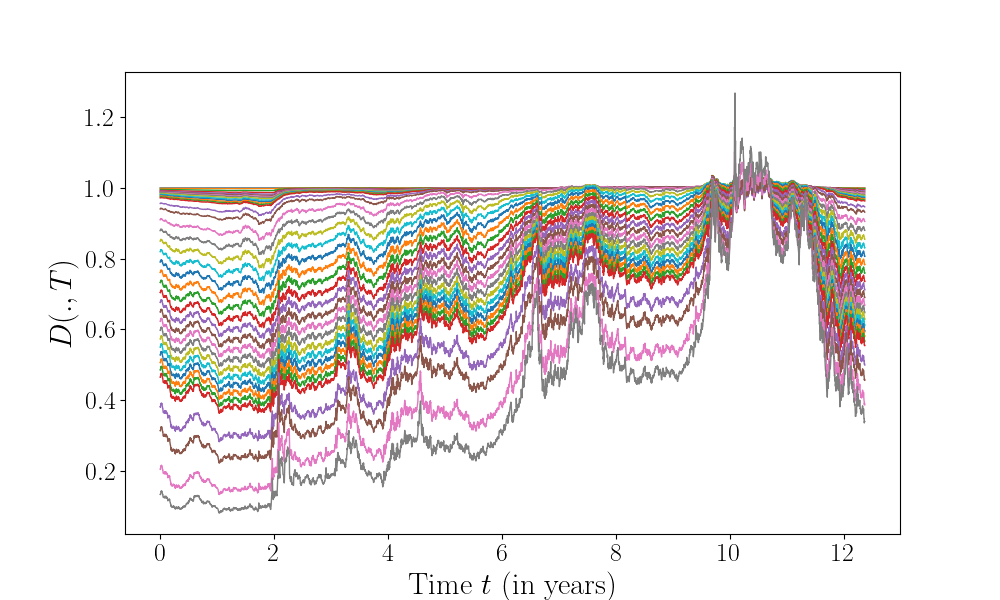

In [13]:
fig = plt.figure()
plt.plot(time_in_years,DCFs)
plt.xlabel(r'Time $t$ (in years)')
plt.ylabel(r'$D(.,T)$')
#plt.title(r'Discount Factors')
plt.savefig('DCF_time_direction', bbox_inches='tight', pad_inches=0.05, dpi=400)
plt.show()

<IPython.core.display.Javascript object>


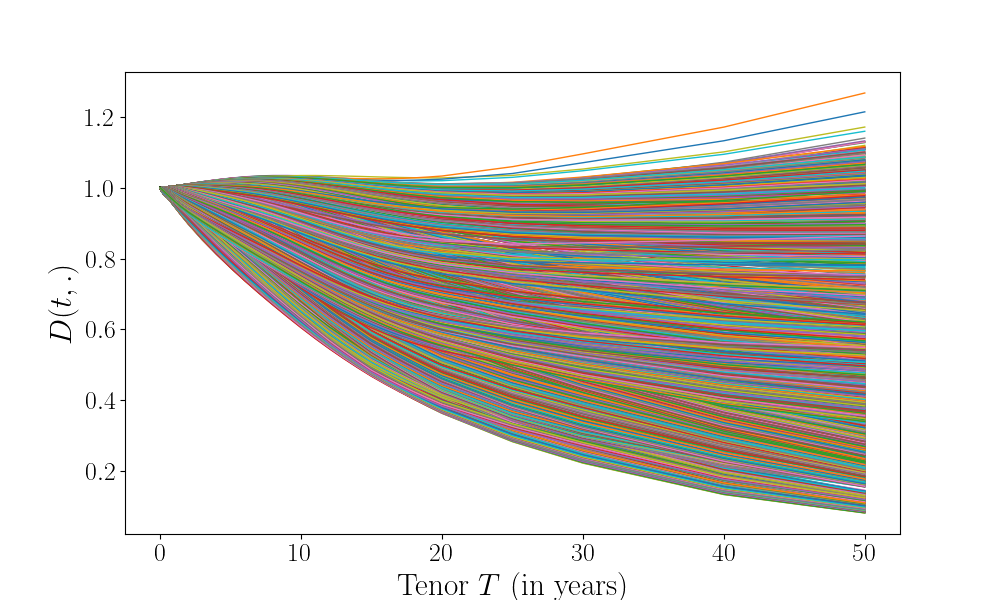

In [24]:
fig = plt.figure()
plt.plot(tenors_in_years,DCFs.transpose())
plt.xlabel(r'Tenor $T$ (in years)')
plt.ylabel(r'$D(t,.)$')
#plt.title(r'Discount Factors')
plt.savefig('DCF_tenor_direction', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

numpy.matrix

(4513, 38)

4513

38

<IPython.core.display.Javascript object>


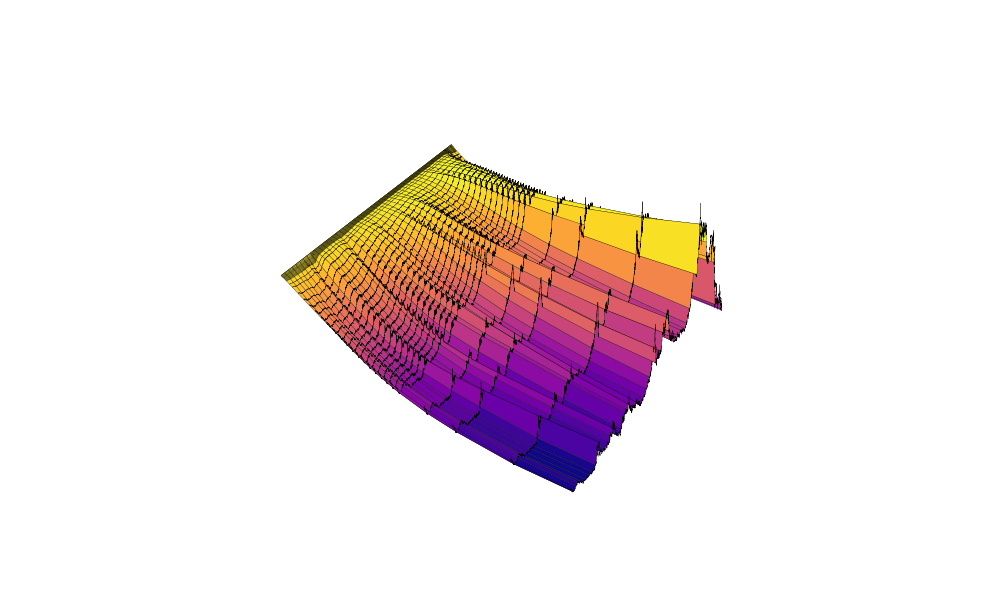

In [18]:
#Set up vectors for surface plot
display(type(hist_zerorates))
z_vals = np.squeeze(np.asarray(DCFs))
y_vals = time_in_years
x_vals = np.array(tenors_in_years)

display(z_vals.shape, len(y_vals), len(x_vals))
fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_xlabel('Tenors (in years)',labelpad=10)
ax.set_ylabel('Time (in years)',labelpad=10)
ax.set_zlabel('Zero Rates',labelpad=10)
#ax.set_title(r'Zero Rates Surface $(t,T)$',size=25)

surf = ax.plot_surface(X,Y,z,cmap='plasma', 
                       linewidth=0.1, edgecolors='k', lw=0.2)

ax.set_axis_off()
plt.tight_layout()

ax.set_box_aspect([2,2,1.1])

plt.savefig('ForwardRate_Surface_without_axes', bbox_inches='tight', pad_inches=0.01, dpi=400)
#ax.set_ylim3d(-0.5,5.5)

#ax.view_init(-70,60)

#fig.colorbar(surf, shrink=0.5, aspect=5)

numpy.matrix

(4513, 38)

4513

38

<IPython.core.display.Javascript object>


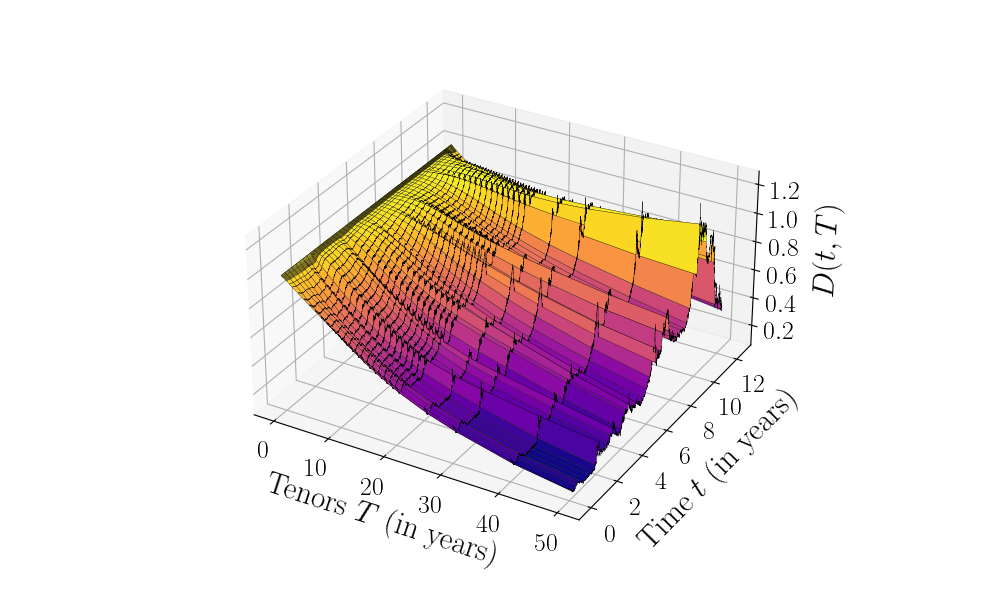

In [20]:
#Set up vectors for surface plot
display(type(hist_zerorates))
z_vals = np.squeeze(np.asarray(DCFs))
y_vals = time_in_years
x_vals = np.array(tenors_in_years)

display(z_vals.shape, len(y_vals), len(x_vals))
fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_xlabel('Tenors $T$ (in years)',labelpad=10)
ax.set_ylabel('Time $t$ (in years)',labelpad=10)
ax.set_zlabel('$D(t,T)$',labelpad=10)
#ax.set_title(r'Zero Rates Surface $(t,T)$',size=25)

surf = ax.plot_surface(X,Y,z,cmap='plasma', 
                       linewidth=0.1, edgecolors='k', lw=0.2)

#ax.set_axis_off()
plt.tight_layout()

ax.set_box_aspect([2,2,1.1])

plt.savefig('DCF_Surface_with_axes', bbox_inches='tight', pad_inches=0.01, dpi=400)
#ax.set_ylim3d(-0.5,5.5)

#ax.view_init(-70,60)

#fig.colorbar(surf, shrink=0.5, aspect=5)

__NOTE__ These are forward rates $F(t;T_1,T_2)$ and NOT instantaneous forward rates $f(t,x)$.

We now compute daily changes $\delta F(t;T_i,T_{i+1})\equiv F(t+\epsilon;T_i,T_{i+1})-F(t;T_i,T_{i+1})$.

We interpolate the tenors for daily values to approximate the instantaneous forward rate.

Due to the stochastic nature of the forward rates in the time-direction $t$ an interpolation (linear or spline) is not easily achieved. We can however interpolate the curve $f(t,.)$ for every value of $t$.

We will construct a matrix in which each column is the interpolated zero rate curve $Z(t,.)$ with daily step in the maturity $T$ direction. To migitate the required memory, we will only consider the final 5 years of data together with tenors up to 10 years

In [21]:
#To reduce noise we try to consider only tenors ranging from 2y - 12y
zero_rates_interp = np.zeros((5*365, int((13*365-3*365))))
print(zero_rates_interp.shape)

#Set up range of daily tenors from 1 day to 10 years (in days); To mitigate required memory even further monthly or 3-monthly 
#interpolation points may be used
daily_tenor = np.linspace(3*365,13*365,zero_rates_interp.shape[1])
print(len(daily_tenor))

for t in range(5*365):
    #zero_rates_interp[t,:]=np.interp(daily_tenor/365, tenors_in_years, np.array(hist_zerorates)[-t,:])
    #zero_rates_interp[t,:]=PchipInterpolator(tenors_in_years,np.array(hist_zerorates)[-t,:])(daily_tenor/365)
    #bspl = make_interp_spline(tenors_in_years, np.array(hist_zerorates)[-t,:], k=3)
    #zero_rates_interp[t,:]= bspl(daily_tenor/365)
    
    cspl = CubicSpline(tenors_in_years, np.array(hist_zerorates)[-t,:], bc_type='clamped')
    zero_rates_interp[t,:]= cspl(daily_tenor/365)


(1825, 3650)
3650


We argued earlier that we can approximate the instantaneous forward rate $f(t,T)$ as the forward rate over 1 trading day, i.e. $F(t;T,T+\epsilon)$

In [22]:
display(zero_rates_interp.shape)
display(len(daily_tenor), len(time_in_years))
inst_forward_rates = np.zeros((zero_rates_interp.shape[0], zero_rates_interp.shape[1]-1))

for t in range(zero_rates_interp.shape[0]):
    for T in range(len(daily_tenor)-1):
        DCF1 = (1+zero_rates_interp[t,T])**(-daily_tenor[T]/365)
        DCF2 = (1+zero_rates_interp[t,T+1])**(-daily_tenor[T+1]/365)
        inst_forward_rates[t,T]=-np.log(DCF2/DCF1)/(1/tradeyear)


(1825, 3650)

3650

4513

<IPython.core.display.Javascript object>


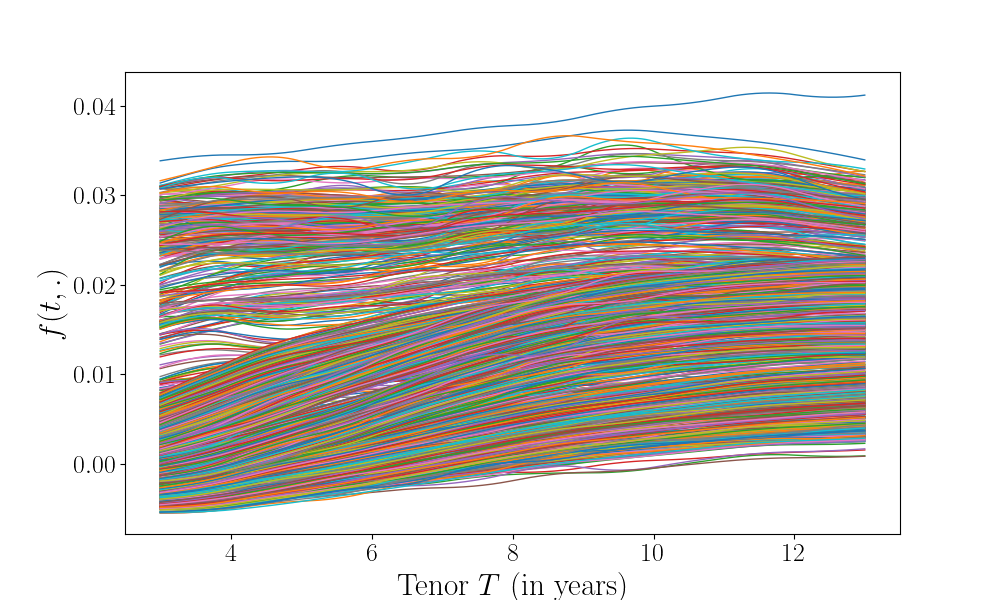

In [31]:
fig = plt.figure()

plt.plot(daily_tenor[0:-1]/365, inst_forward_rates.transpose())
plt.xlabel('Tenor $T$ (in years)')
plt.ylabel('$f(t,.)$')
#plt.title("Instantaneous Forward Rates $f(t,.)$")
plt.savefig('interpolated_foward_rate_tenor', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

1825


<IPython.core.display.Javascript object>


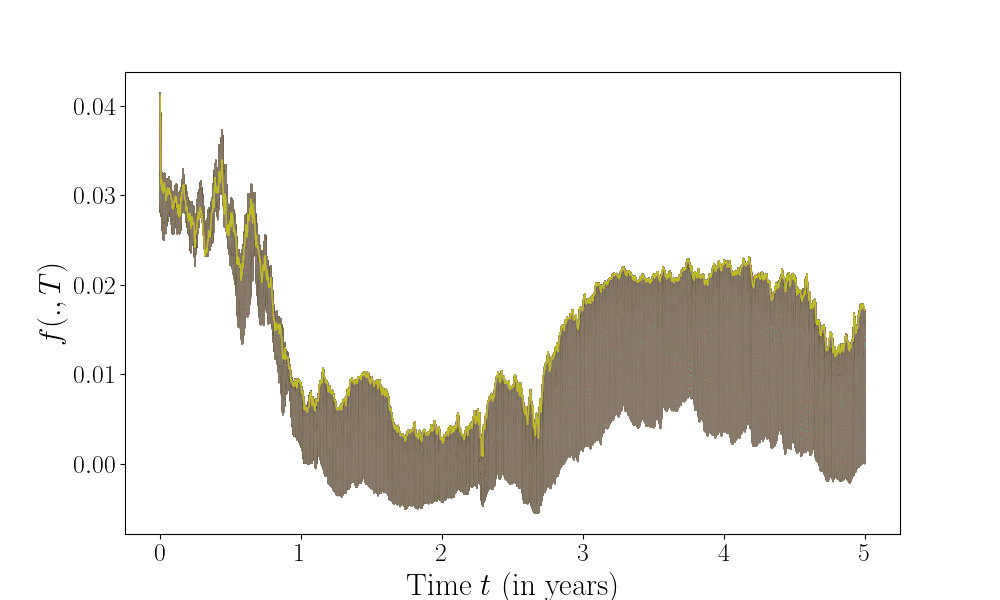

In [26]:
print(5*365)
fig = plt.figure()

plt.plot(np.arange(0,5*365)/365, inst_forward_rates)
plt.xlabel('Time $t$ (in years)')
plt.ylabel('$f(.,T)$')
#plt.title("Instantaneous Forward Rates $f(.,s)$")
plt.savefig('interpolated_forward_rates_time', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

(3649, 1825)

3649

1825

<IPython.core.display.Javascript object>


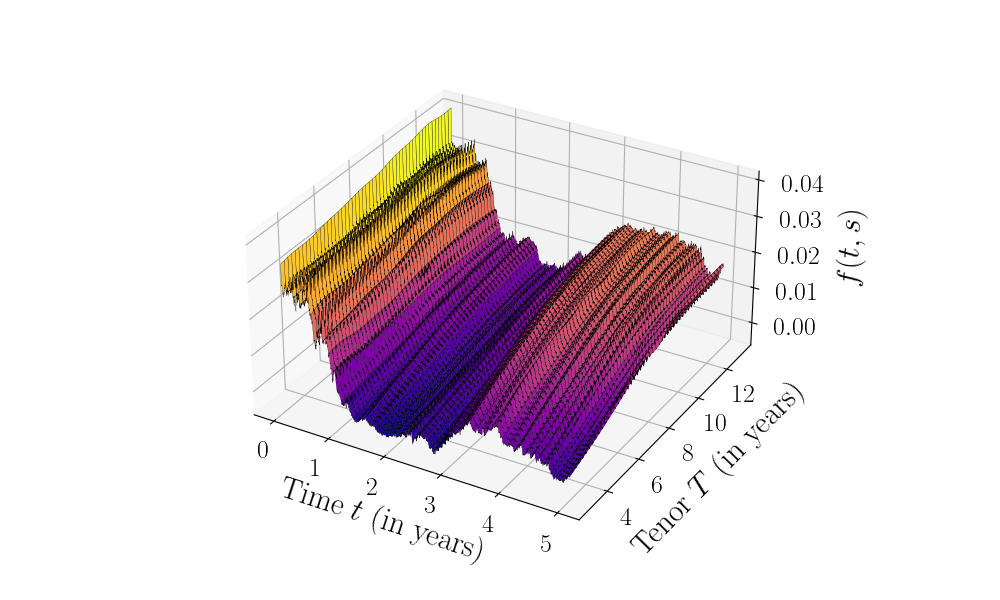

In [98]:
#Set up vectors for surface plot
#display(type(hist_zerorates))
z_vals = np.squeeze(np.asarray(inst_forward_rates.transpose()))
x_vals = np.arange(0,5*365)/365
y_vals = np.array(daily_tenor[0:-1]/365)

display(z_vals.shape, len(y_vals), len(x_vals))
fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_ylabel('Tenor $T$ (in years)',labelpad=10)
ax.set_xlabel('Time $t$ (in years)',labelpad=10)
ax.set_zlabel('$f(t,s)$',labelpad=20)
#ax.set_title(r'Zero Rates Surface $(t,T)$',size=25)

surf = ax.plot_surface(X,Y,z,cmap='plasma', 
                       linewidth=0.1, edgecolors='k', lw=0.2)

ax.tick_params(axis='z', pad=10)

#ax.set_axis_off()
plt.tight_layout()

ax.set_box_aspect([2,2,1.1])

plt.savefig('InstForwardRate_Surface_with_axes', dpi=400)
#ax.set_ylim3d(-0.5,5.5)

#ax.view_init(-70,60)

#fig.colorbar(surf, shrink=0.5, aspect=5)

(1825, 3649)

1825

3649

<IPython.core.display.Javascript object>


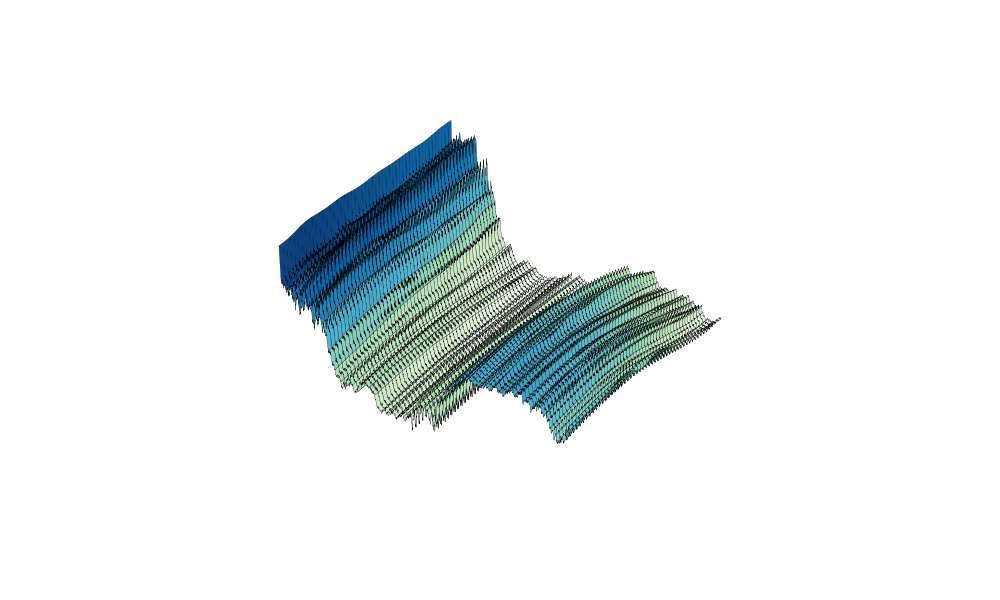

In [30]:
#Set up vectors for surface plot
#display(type(hist_zerorates))
z_vals = np.squeeze(np.asarray(inst_forward_rates))
y_vals = np.arange(0,5*365)/365
x_vals = np.array(daily_tenor[0:-1]/365)

display(z_vals.shape, len(y_vals), len(x_vals))
fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_xlabel('Tenors (in years)',labelpad=10)
ax.set_ylabel('Time (in years)',labelpad=10)
ax.set_zlabel('f(t,s)',labelpad=20)
#ax.set_title(r'Zero Rates Surface $(t,T)$',size=25)

surf = ax.plot_surface(X,Y,z,cmap=cm.GnBu, 
                       linewidth=0.1, edgecolors='k', lw=0.2)

ax.tick_params(axis='z', pad=10)

ax.set_box_aspect([2,2,1.1])

ax.set_axis_off()

ax.view_init(35,30)


plt.tight_layout()
plt.savefig('InstForwardRate_Surface_without_axes', bbox_inches='tight', pad_inches=0.01, dpi=400)
#ax.set_ylim3d(-0.5,5.5)


#fig.colorbar(surf, shrink=0.5, aspect=5)

In [32]:
instFWR_normalized_correlation = np.corrcoef(inst_forward_rates.transpose())

(3649, 3649)

3649

3649

<IPython.core.display.Javascript object>


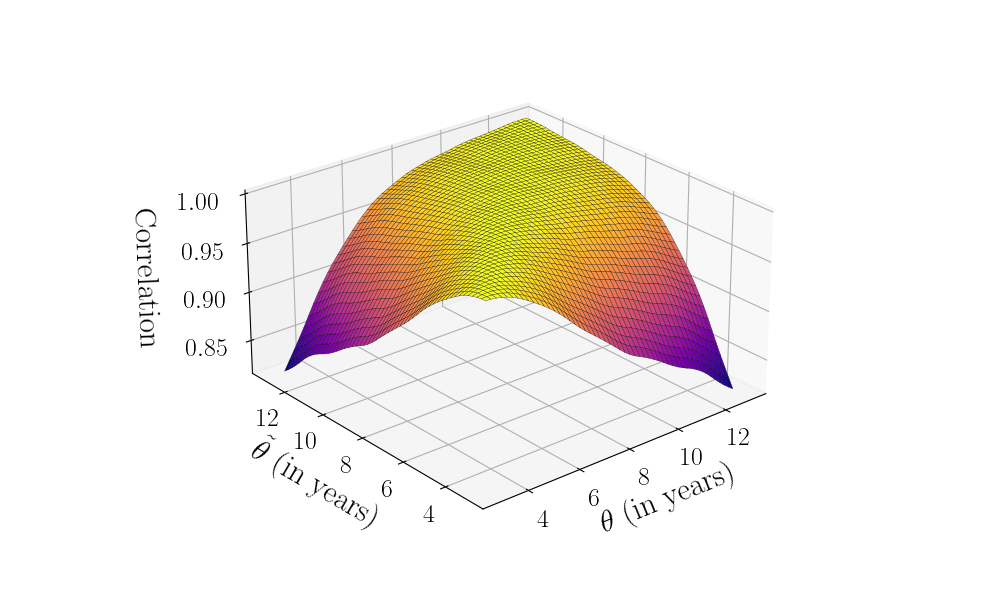

In [36]:
#Set up vectors for surface plot
z_vals = instFWR_normalized_correlation
y_vals = np.array(daily_tenor[0:-1]/365)
x_vals = np.array(daily_tenor[0:-1]/365)

display(z_vals.shape,len(y_vals),len(x_vals))

fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_xlabel(r'$\theta$ (in years)',labelpad=10)
ax.set_ylabel(r'$\tilde{\theta}$ (in years)',labelpad=10)
ax.set_zlabel('Correlation',labelpad=20)
#ax.set_title(r'Empirical Correlation $\mathcal{C}(\theta,\tilde{\theta})$',size=25)

surf = ax.plot_surface(X,Y,z,cmap='plasma', 
                       linewidth=0.1, edgecolors='k', lw=0.2)

ax.tick_params(axis='z', pad=10)

ax.set_box_aspect([2,2,1.1])


plt.tight_layout()
#ax.set_ylim3d(-0.5,5.5)

ax.view_init(25,230)

plt.savefig('empirical_correlation_surface', dpi=400)

#fig.colorbar(surf, shrink=0.5, aspect=5)

In [37]:
def D_theta(theta1, theta2, mu):
    normalization_factor = np.sqrt(mu/2*(np.exp(-mu*(theta1+theta1))
                                         +np.exp(-mu*(abs(theta1-theta1))))*mu/2*(np.exp(-mu*(theta2+theta2))
                                                                                  +np.exp(-mu*(abs(theta2-theta2)))))
    return mu/2*(np.exp(-mu*(theta1+theta2))+np.exp(-mu*(abs(theta1-theta2))))/normalization_factor

In [94]:
z_ft = np.matrix([[D_theta(theta1, theta2,0.177) for theta1 in x_vals] for theta2 in y_vals])

In [93]:
z_ft2 = np.matrix([[D_theta(theta1, theta2,0.05897592) for theta1 in x_vals] for theta2 in y_vals])

(3649, 3649)

3649

3649

<IPython.core.display.Javascript object>


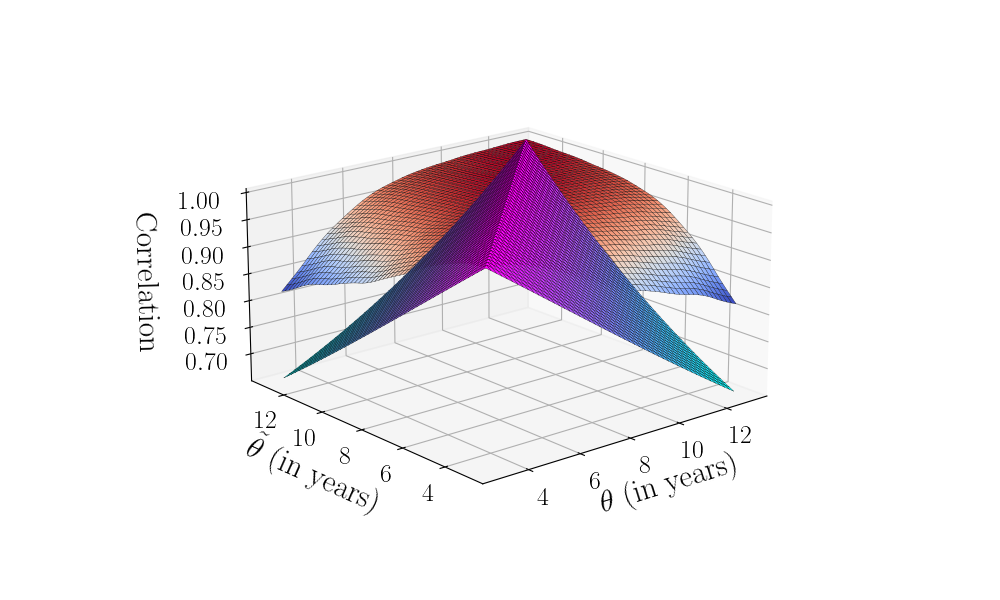

In [95]:
#Set up vectors for surface plot
z_vals = instFWR_normalized_correlation
y_vals = np.array(daily_tenor[0:-1]/365)
x_vals = np.array(daily_tenor[0:-1]/365)

display(z_vals.shape,len(y_vals),len(x_vals))

fig = plt.figure()

#fig.set_size_inches(25, 10)

ax = fig.add_subplot(111,projection='3d')

x,y,z= x_vals,y_vals,z_vals

X,Y=np.meshgrid(x,y)

ax.set_xlabel(r'$\theta$ (in years)',labelpad=10)
ax.set_ylabel(r'$\tilde{\theta}$ (in years)',labelpad=11)
ax.set_zlabel('Correlation',labelpad=20)
#ax.set_title(r'Empirical Correlation $\mathcal{C}(\theta,\tilde{\theta})$',size=25)

surf = ax.plot_surface(X,Y,z,cmap=cm.coolwarm, 
                       linewidth=0.1, edgecolors='k', lw=0.2)

surf = ax.plot_surface(X,Y,z_ft2,cmap=cm.cool, 
                       linewidth=0.1, edgecolors='k', lw=0.2)

plt.tight_layout()
ax.tick_params(axis='z', pad=10)

ax.set_box_aspect([2,2,1.1])


plt.tight_layout()
#ax.set_ylim3d(-0.5,5.5)

ax.view_init(18,230)

plt.savefig('empirical_theoretical_correlation_comparison', pad_inches=0.01, bbox_inches='tight', dpi=400)
#fig.colorbar(surf, shrink=0.5, aspect=5)

We have obtained a calibrated value for $\mu$ and $\sigma(\theta_{\text{min}})$. We will use these values to compare the value of an option on a Zero Coupon Bond in both the one-factor HJM model and the free field theory model. We will in both cases assume a constant volatility. __NOTE__: this is a enormous assumption and most likely a wrongful one. However, if we make the same assumption in both models, a comparison of the price result is still meaningfull.

The price for the option on the ZCB in one-factor HJM is given by

$$C(t_0;K,t_*,T) = P(t_0,T)N(d_+)-KP(t_0,t_*)N(d_-),$$

where 

$$d_\pm = \frac{\log\left[\frac{P(t_0,T)}{P(t_0,t_*)K}\right]\pm\frac{1}{2}\sigma^2(T-t_*)^2(t_*-t_0)}{\sigma(T-t_*)\sqrt{t_*-t_0}}$$

In the case of the free field theory, one has

$$C(t_0;K,t_*,T) = P(t_0,t_*)[FN(d_+)-KN(d_-)],$$

where

$$F\equiv F(t)=\exp\left[-\int_{t_*}^Tdx f(t,x)\right]$$

and

$$d_\pm = \frac{1}{q}\left[\log\frac{F}{K} \pm \frac{q^2}{2}\right]$$

for

$$q^2 = \int_{t_0}^{t_*}dt\int_{t_*}^Tdx dx' \sigma D(x,x';t_0)\sigma$$
$$= \sigma^2\int_{t_0}^{t_*}dt\int_{t_*}^Tdx dx' D(x,x';t_0)$$

For the propagator $D(x,x';t)$ we use

$$D(x,x';t_0) = \frac{\mu}{2}\left[e^{-\mu|x-x'|}+e^{-\mu(x+x'-2t_0)}\right]$$

or, for $\theta\equiv x-t_0$

$$D(\theta,\theta'; t_0) = \frac{\mu}{2}\left[e^{-\mu|\theta-\theta'|}+e^{-\mu(\theta+\theta')}\right]$$

Note that 

$$F=\exp\left[-\int_{t_*}^Tdx f(t,x)\right]=\exp\left[-\int_{t}^Tdx f(t,x)+\int_{t}^{t_*}dx f(t,x)\right]=\frac{\exp\left[-\int_{t}^Tdx f(t,x)\right]}{\exp\left[-\int_{t}^{t_*}dx f(t,x)\right]}=\frac{P(t,T)}{P(t,t_*)}$$

In [42]:
vol_min = 0.05

def vol(theta):
    return vol_min

def P(f,t1, t2):
    """"
    t1, t2 are elements of daily_tenor
    f is the array of instantaneous forward rates f(t1,x) for x in [t1,t2]
    """
    
    """
    Given the value of t1, we must pick the correct row in the dataset f.
    This means we we can only take values for t1 that are in the time range available to dataset f.
    Even then, t1 is an element from daily_tenor, whose values differ from the time range since we consider the interpolations
    on different intervals of 3 trade years. 
    
    We should thus find a value for t1 that falls within the interval of the considered dataset (or vice versa, pick the dataset
    corresponding to the value t1).
    Then we need to find what row of the dataset is associated to time t1 by 
    1) finding the value in hist_timeline closest to t1, call this value t'
    2) obtaining the index of t', this should be t' itself
    3) find the row in dataset f that corresponds to t'; e.g. if t'= 987, it lies in [3*252,6*252], such that the correct row 
       index in the dataset is 987-3*252
    """  
    
    index_t1 = list(daily_tenor).index(t1)
    index_t2 = list(daily_tenor).index(t2)
    
    #print(index_t1, index_t2)
    #print(len(f[t1:t2]), len(daily_tenor[2*t1:t2+t1]))
    #print(f[:,t1:t2].shape, daily_tenor[2*t1:t2+t1+1].shape)
    if t1 == t2:
        return 1  
    
    else:
        f_index = min(hist_timeline, key = lambda x: abs(x-t1))
        #print(f_index)
        
        exponent = -integrate.simps(f[index_t1:index_t1+1,index_t1:index_t2+1], 
                                    daily_tenor[index_t1:index_t2+1]/365, dx=0.1)
        #print(exponent)
        
        #The function returns the Zero Coupon Bond Value P(t1,t2)
        return np.exp(exponent[0])

def d_HJM(t0,t1,T,f,K, sign):
    
    #Use sign == 0 for d_+; sign == 1 for d_-
    
    index_t0 = list(daily_tenor).index(t0)
    index_t1 = list(daily_tenor).index(t1)
    index_T = list(daily_tenor).index(T)
    t_0, t_1, T_ = t0/365, t1/365, T/365
    
    #print(np.log(P(f,t0,T)/(P(f,t0,t1)*K)))
    
    nominator = np.log(P(f,t0,T)/(P(f,t0,t1)*K))+(-1)**sign*1/2*vol_min**2*(T_-t_1)**2*(t_1-t_0)
    denominator = vol_min*(T_-t_1)*np.sqrt(t_1-t_0)
    
    return nominator/denominator

def C_HJM(t0,t1,T,f,K):
    
    return P(f,t0,T)*norm.cdf(d_HJM(t0,t1,T,f,K,0))-K*P(f,t0,t1)*norm.cdf(d_HJM(t0,t1,T,f,K,1))

    
    
    
#------ FUNCTIONS FOR FIELD THEORY PRICE -------------

def D_theta(theta1, theta2, mu):
    
    normalization_factor = np.sqrt(mu/2*(np.exp(-mu*(theta1+theta1))
                                         +np.exp(-mu*(abs(theta1-theta1))))*mu/2*(np.exp(-mu*(theta2+theta2))
                                                                                  +np.exp(-mu*(abs(theta2-theta2)))))
    return mu/2*(np.exp(-mu*(theta1+theta2))+np.exp(-mu*(abs(theta1-theta2))))/normalization_factor

def D_TFR_norm(x,y,T_FR,mu):
    
    normalisation_factor = (mu*(math.cosh(mu*T_FR)+math.cosh(mu*(T_FR-2*(x))))/(2*math.sinh(mu*T_FR)))**(-1/2)*(mu*(math.cosh(mu*T_FR)+math.cosh(mu*(T_FR-2*(y))))/(2*math.sinh(mu*T_FR)))**(-1/2)
    
    return mu*(math.cosh(mu*(T_FR-abs(x-y)))+math.cosh(mu*(T_FR-(x+y))))/(2*math.sinh(mu*T_FR))*normalisation_factor

def q_bounds(t1,T,t):
    return [t1-t,T-t]
    

def q(t_0, t_1, T, mu):
    # t_0, t_1, T are values in years taken from daily_tenors
    # We express these in years
    
    t0 = t_0/365
    t1 = t_1/365
    T_y = T/365 
    
    def integrand(t, theta_1, theta_2):
        return vol(theta_1)*D_theta(theta_1,theta_2, mu)*vol(theta_2)
    
    integral = nquad(integrand, [[t0, t1], q_bounds(t1,T_y,t), q_bounds(t1,T_y,t) ])
    print(integral)
    return np.sqrt(integral[0])


def d(t0,t1,T,mu,f, sign, K):
    """
    use sign == 0 for d_+ and sign == 1 for d_-
    
    NOTE: q takes values from daily_tenors
    
    We take values for t0, t1, T from daily_tenor and we link the value t0, i.e. the time at which the price is calculated, to a 
    value in list "time_in_years"; This is okay (and even necessary) since we consider only a subset of the data (we eliminate
    very short tenors)
    
    """
    if t0==t1:
        return np.inf
    
    else:
        return 1/q(t0,t1,T,mu)*(np.log(P(f,t0,T)/(K*P(f,t0,t1)))+ (-1)**sign*q(t0,t1,T,mu)**2/2)

def C_FT(t0,t1,T,mu,f, K):
    
    #print(d(t0,t1,T,mu,f,0,K), d(t0,t1,T,mu,f,1,K))
    
    return P(f, t0, T)*norm.cdf(d(t0,t1,T,mu,f,0,K)) - K*P(f, t0, t1)*norm.cdf(d(t0,t1,T,mu,f,1,K))

Let us writ a piece of code that starts from the time t0 at which we want to know the ZCB option price, i.e. a value from list
time_in_years. For example take 

$t_0$ = 2 januari 2006 + 2000 days

Then we construct the dataset we need, i.e. $f(t0, x)$ with $x \in [t0,t0+10Y]$ for example


In [43]:
t0 = time_in_years[4494]
max_tenor = 36
display(t0)
t0_index = time_in_years.index(t0)

zr_interp = np.zeros((1,max_tenor*365))
daily_tenor_data = np.arange(1,max_tenor*365)

cspl = CubicSpline(tenors_in_years, np.array(hist_zerorates)[t0_index,:], bc_type='clamped')
zr_data = cspl(daily_tenor_data/365)
fwr_data = []
for zr in range(len(zr_data)-1):
    dcf1 = (1+zr_data[zr])**(-daily_tenor_data[zr]/365)
    dcf2 = (1+zr_data[zr+1])**(-daily_tenor_data[zr+1]/365)
    fwr_data.append(-np.log(dcf2/dcf1)/(1/tradeyear))
    
display(len(daily_tenor_data),len(fwr_data))

12.312328767123288

13139

13138

Write a python function to calculate the zero coupon bond price at time $t$ with maturity $T$. Note that the time $t$ is already fixed since we picked the specific row from "time_in_years", and so $f$ is not a required input anymore.

In [44]:
def P_fwr(t,T):
    index_T = list(daily_tenor_data).index(T)
    
    #print(len(fwr_data[0:index_T]), len(daily_tenor[0:index_T]))
    exponent = -integrate.simps(fwr_data[0:index_T+1], 
                                daily_tenor_data[0:index_T+1]/365, dx=0.1)
    return np.exp(exponent)

P_data = [P_fwr(t0, T) for T in daily_tenor_data[0:-1]]

<IPython.core.display.Javascript object>


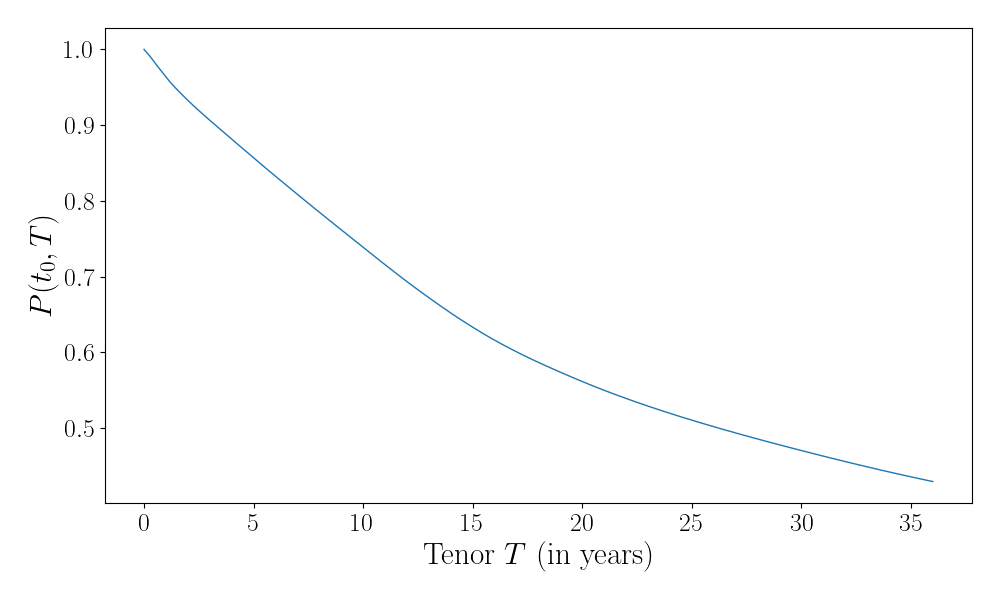

In [47]:
fig = plt.figure()
plt.plot(daily_tenor_data[0:-1]/365, P_data)
plt.xlabel('Tenor $T$ (in years)')
plt.ylabel('$P(t_0,T)$')
plt.tight_layout()
plt.savefig('ZCB_Price_from_Data', pad_inches=0.01, bbox_inches='tight', dpi=400)
#plt.title('Zero Coupon Bond Price $P(t, . )$')

Suppose we aim to calculate the price of the ZCB Call Option with option expiry at time $t_1\geq t_0$ and ZCB maturity at time $T\geq t_0$. Naturally $t_0\leq t_1\leq T$. Note that $t_1,\ T$ are NOT elements of $\text{daily_tenor_data}$, however $\theta\equiv T-t_0$ and $\theta_*\equiv t_*- t_0$ are.

Also note that, in the equation for $d_\pm$, we have $T-t_*=T-t_0-(t_*-t_0)=\theta-\theta_*$.

Hence

$$d_\pm = \frac{\log\left[\frac{P(t_0,T)}{P(t_0,t_*)K}\right]\pm\frac{1}{2}\sigma^2(\theta-\theta_*)^2(\theta_*)}{\sigma(\theta-\theta_*)\sqrt{\theta_*}}$$

We first define $\theta$ and $\theta_*$:

In [48]:
vol_min = 0.005

option_expiry = 5
bond_maturity = 20
theta1 = daily_tenor_data[option_expiry*365] 
theta2 = daily_tenor_data[bond_maturity*365]

P_t0 = P_fwr(t0,theta2)

def d_fwr_HJM(t0, theta1, theta2, K, sign, vol):
    
    nominator = np.log(P_fwr(t0,theta2)/(K*P_fwr(t0,theta1))) + (-1)**sign*1/2*vol**2*((theta2-theta1)/365)**2*theta1/365
    denominator = vol*((theta2-theta1)/365)*np.sqrt(theta1/365)
    
    return nominator/denominator

display(P_t0)

0.5614888246391508

In [49]:
K = 0.8*P_t0

def C_fwr_HJM(t0,theta1,theta2,K, vol):
    
    return P_fwr(t0,theta2)*norm.cdf(d_fwr_HJM(t0,theta1,theta2,K,0, vol))-K*P_fwr(t0,theta1)*norm.cdf(d_fwr_HJM(t0,theta1,theta2,K,1, vol))

display(C_fwr_HJM(t0, theta1, theta2, 0.0294, vol_min))

0.5363014587607671

In [50]:
C_HJM_data = [C_fwr_HJM(t0, theta, theta2,K, vol_min) for theta in daily_tenor_data[0:option_expiry*365]]

<IPython.core.display.Javascript object>


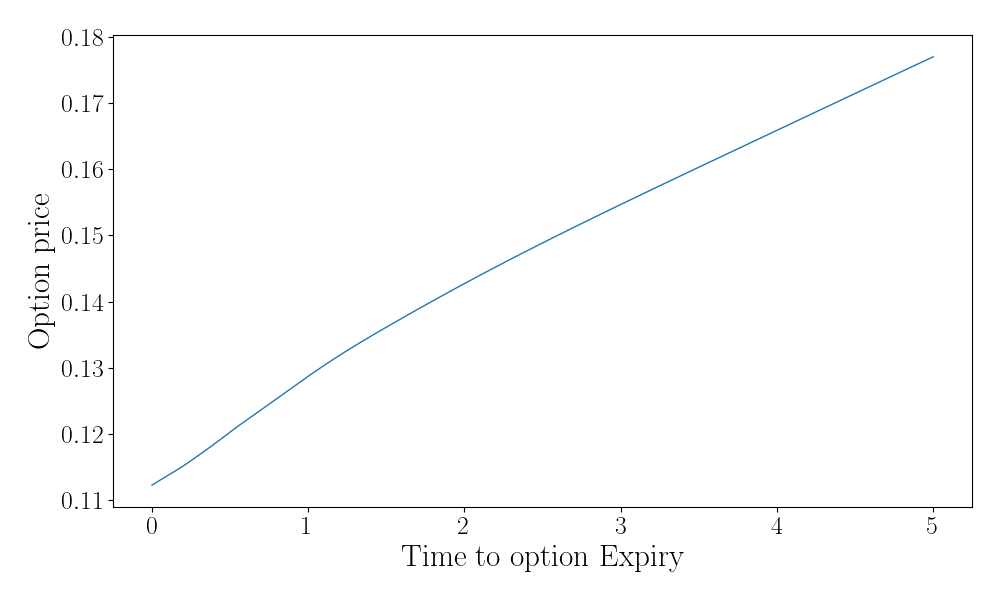

In [51]:
fig = plt.figure()
plt.plot(daily_tenor_data[0:option_expiry*365]/365, C_HJM_data, label='Option Value')
#plt.plot(daily_tenor_data[0:option_expiry*365]/365, C_HJM_data-intrinsic_value(theta1, theta2,K), label='Option - Intrinsic Value')
#plt.plot(daily_tenor_data[0:option_expiry*365]/365, [intrinsic_value(theta, theta2, K) for theta in daily_tenor_data[0:option_expiry*365]])
#plt.axhline(y=P_t0, color='r', linestyle='--', label='$C(t_0;T,T,K)$')
plt.xlabel('Time to option Expiry')
plt.ylabel('Option price')
#plt.title('HJM ZCB Call Option in function of the time to option expiry')
#plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('ZCB_Call_Option_Price_HJM', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

We now attempt to achieve the same in the field theory model. For this we require an extra function $q$. In the literature, we have 

$$q^2 = \int_{t_0}^{t_*}dt\int_{t_*}^Tdx dx' \sigma D(x,x';t_0)\sigma$$
$$= \sigma^2\int_{t_0}^{t_*}dt\int_{t_*}^Tdx dx' D(x,x';t_0)$$

For the propagator $D(x,x';t)$ we use

$$D(x,x';t_0) = \frac{\mu}{2}\left[e^{-\mu|x-x'|}+e^{-\mu(x+x'-2t_0)}\right]$$

or, for $\theta\equiv x-t_0$

$$D(\theta,\theta'; t_0) = \frac{\mu}{2}\left[e^{-\mu|\theta-\theta'|}+e^{-\mu(\theta+\theta')}\right]$$

such that

$$q^2= \sigma^2\int_{t_0}^{t_*}dt\int_{t_*-t_0}^{T-t_0}d\theta d\theta' D(\theta,\theta';t_0)$$
$$=\sigma^2\int_{t_0}^{\theta_*+t_0}dt\int_{\theta_*}^{\theta_0}d\theta d\theta' D(\theta,\theta';t_0),$$

where we now defined $\theta_0\equiv T-t_0$ and $\theta_*\equiv  t_*-t_0$.

In [52]:
T_FR = 30
def q_fwr(t_0, theta_1, theta_2, mu):
        
    t0 = t_0/365
    theta1 = theta_1/365
    theta2 = theta_2/365
    
    def integrand(t, theta_11, theta_12):
        return vol(theta_11)*D_theta(theta_11,theta_12, mu)*vol(theta_12)
    
    integral = tplquad(integrand, t0, theta1+t0, theta1, theta2, theta1, theta2)
    
    return np.sqrt(integral[0])

def q_fwr_TFR(t_0, theta_1, theta_2, mu):
        
    t0 = t_0/365
    theta1 = theta_1/365
    theta2 = theta_2/365
    
    def integrand(t, theta_11, theta_12):
        return vol(theta_11)*D_TFR_norm(theta_11,theta_12, max_tenor+T_FR, mu)*vol(theta_12)
    
    integral = tplquad(integrand, t0, theta1+t0, theta1, theta2, theta1, theta2)
    
    return np.sqrt(integral[0])

def d_fwr_FT(q,t0, theta1, theta2, mu, sign, K):
    
    #q = q_fwr(t0, theta1, theta2, mu)
    
    d = 1/q*(np.log(P_fwr(t0,theta2)/(K*P_fwr(t0,theta1))) + q**2/2)
    
    if sign == 0:  
        return d
    else:
        return d-q

def C_fwr_FT(t0, theta1, theta2, mu, K):
    
    q = q_fwr(t0, theta1, theta2, mu)
    
    d = d_fwr_FT(q, t0, theta1, theta2, mu, 0, K)
    
    return P_fwr(t0, theta2)*norm.cdf(d) - K*P_fwr(t0, theta1)*norm.cdf(d-q)

def C_fwr_TFR_FT(t0, theta1, theta2, mu, K):
    
    q = q_fwr_TFR(t0, theta1, theta2, mu)
    
    d = d_fwr_FT(q, t0, theta1, theta2, mu, 0, K)
    
    return P_fwr(t0, theta2)*norm.cdf(d) - K*P_fwr(t0, theta1)*norm.cdf(d-q)

In [60]:
start = time.time()

display(C_fwr_FT(t0, theta1, theta2, 0.082, K))

even_points = np.arange(1, option_expiry*365, 100)
uneven_points = np.arange(int(option_expiry*365/3), int(option_expiry*365*2/3), 20)
end_point = np.array([option_expiry*365])
eval_points = np.sort(np.concatenate((even_points, uneven_points, end_point)))

#mu_points = [5*10e-15, 0.0005, 0.005, 0.02, 0.08, 0.1, 0.5]

C_FT_time_to_expiry = [C_fwr_FT(t0, theta, theta2, 2, K) for theta in eval_points]
C_FT_HJM_limit = [C_fwr_FT(t0, theta, theta2, 1e-15, K) for theta in eval_points]
C_TFR_FT_time_to_expiry = [C_fwr_TFR_FT(t0, theta, theta2, -2, K) for theta in eval_points]

#C_FT_data = [[C_fwr_FT(t0, theta, theta2, muval, K) for theta in eval_points] for muval in mu_points]
#C_TFR_FT_data = [[C_fwr_TFR_FT(t0, theta, theta2, muval, K) for theta in eval_points] for muval in mu_points]

#display(C_fwr_TFR_FT(t0, theta1, theta2, 0.082, K))

end = time.time()
display(end-start)

0.17668190594112004

297.0723488330841

<IPython.core.display.Javascript object>


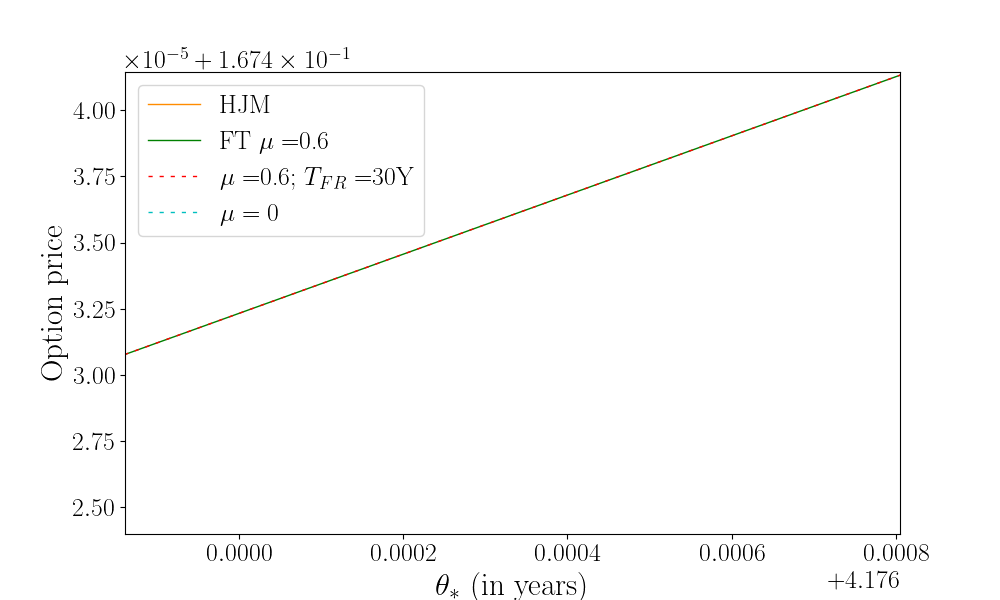

In [61]:
fig = plt.figure()
plt.plot(daily_tenor_data[0:option_expiry*365]/365, C_HJM_data, '-', label='HJM', color='darkorange')
plt.plot(eval_points/365, C_FT_time_to_expiry, '-', label = 'FT $\mu = $'+str(0.6), color='g')
plt.plot(eval_points/365, C_TFR_FT_time_to_expiry, '--',dashes=(3,5), label='$\mu = $'+str(0.6)+'; $T_{FR}= $'+str(T_FR)+'Y', color='r')
plt.plot(eval_points/365, C_FT_HJM_limit, '--',dashes=(3,5), label='$\mu= 0$', color='c')
#plt.plot(eval_points/365, C_FT_time_to_expiry2, '*', label = 'FT $\mu = $'+str(2.82))


plt.legend()
plt.xlabel(r'$\theta_*$ (in years)')
plt.ylabel('Option price')
#plt.title('ZCB Call Option $C(t_0;\ .,\ T, K)$')
plt.savefig('ZCB_Option_prices_vs_Time_to_Expiry', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

We see that the field theory ZCB option price has more structure due to the parameter $\mu$. However, to obtain a relevant calibration and comparison between the two models, we must calibrate to market prices (instead of using historical volatility of daily changes of the instantaneous forward rate). We can use market prices of "caplets", which are smaller instruments underlying the interest rate "cap".

In [63]:
caplet_dataframe = pd.read_excel(r'caps.xlsx', sheet_name='Sheet2', engine='openpyxl')
pd.options.display.max_rows = 10
display(caplet_dataframe)

Calculation        Calculation.1               Fixing  \
0            Start date             End date                 Date   
1   2023-05-04 00:00:00  2023-11-06 00:00:00  2023-05-02 00:00:00   
2   2023-11-06 00:00:00  2024-05-06 00:00:00  2023-11-02 00:00:00   
3   2024-05-06 00:00:00  2024-11-04 00:00:00  2024-05-02 00:00:00   
4   2024-11-04 00:00:00  2025-05-05 00:00:00  2024-10-31 00:00:00   
..                  ...                  ...                  ...   
17  2031-05-05 00:00:00  2031-11-04 00:00:00  2031-04-30 00:00:00   
18  2031-11-04 00:00:00  2032-05-04 00:00:00  2031-10-31 00:00:00   
19  2032-05-04 00:00:00  2032-11-04 00:00:00  2032-04-30 00:00:00   
20  2032-11-04 00:00:00  2033-05-04 00:00:00  2032-11-02 00:00:00   
21                  NaN                  NaN                  NaN   

                Payment    Strike      Main      Rate         Disc  \
0                  Date       NaN       Vol       NaN       Factor   
1   2023-11-06 00:00:00  2.940047  1.290479  3.645000          NaN   
2   2024-05-06 00:00:00  2.940047  1.290479  3.749686     0.964868   
3   2024-11-04 00:00:00  2.940047  1.314624  3.352947     0.949826   
4   2025-05-05 00:00:00  2.940047  1.338563  3.006191       0.9367   
..                  ...       ...       ...       ...          ...   
17  2031-11-04 00:00:00  2.940047  1.002958  2.954733     0.788795   
18  2032-05-04 00:00:00  2.940047  0.981926  2.984592     0.777568   
19  2032-11-04 00:00:00  2.940047   0.96326  3.016758     0.766086   
20  2033-05-04 00:00:00  2.940047  0.945548  3.049106     0.754893   
21                  NaN       NaN       NaN       NaN  Cap Premium   

        Discounted  
0             Flow  
1              NaN  
2    457249.587017  
3    382831.699562  
4    347785.659049  
..             ...  
17    579029.49847  
18   588856.678182  
19   609138.140187  
20   612767.721496  
21  9170677.307126  

[22 rows x 9 columns]

In [64]:
#Remove unwanted rows
caplet_df = caplet_dataframe[1:caplet_dataframe.shape[0]-1]
#Rename Columns
#caplet_df.columns = [str(i) for i in range(caplet_df.shape[1])]
caplet_df = caplet_df.rename(columns = {'Calculation':'Calculation Start Date', 'Calculation.1':'Calculation End Date',
                                        'Fixing':'Fixing Date','Payment': 'Payment Date', 'Main':'Main Vol',
                                        'Disc':'Discount Factor','Discounted': 'Discounted Flow'})
#Remove the row with column names
#caplet_df = caplet_df[0:caplet_dataframe.shape[0]]
display(caplet_df)

Calculation Start Date Calculation End Date          Fixing Date  \
1     2023-05-04 00:00:00  2023-11-06 00:00:00  2023-05-02 00:00:00   
2     2023-11-06 00:00:00  2024-05-06 00:00:00  2023-11-02 00:00:00   
3     2024-05-06 00:00:00  2024-11-04 00:00:00  2024-05-02 00:00:00   
4     2024-11-04 00:00:00  2025-05-05 00:00:00  2024-10-31 00:00:00   
5     2025-05-05 00:00:00  2025-11-04 00:00:00  2025-04-30 00:00:00   
..                    ...                  ...                  ...   
16    2030-11-04 00:00:00  2031-05-05 00:00:00  2030-10-31 00:00:00   
17    2031-05-05 00:00:00  2031-11-04 00:00:00  2031-04-30 00:00:00   
18    2031-11-04 00:00:00  2032-05-04 00:00:00  2031-10-31 00:00:00   
19    2032-05-04 00:00:00  2032-11-04 00:00:00  2032-04-30 00:00:00   
20    2032-11-04 00:00:00  2033-05-04 00:00:00  2032-11-02 00:00:00   

           Payment Date    Strike  Main Vol      Rate Discount Factor  \
1   2023-11-06 00:00:00  2.940047  1.290479  3.645000             NaN   
2   2024-05-06 00:00:00  2.940047  1.290479  3.749686        0.964868   
3   2024-11-04 00:00:00  2.940047  1.314624  3.352947        0.949826   
4   2025-05-05 00:00:00  2.940047  1.338563  3.006191          0.9367   
5   2025-11-04 00:00:00  2.940047  1.344766  2.814620        0.924126   
..                  ...       ...       ...       ...             ...   
16  2031-05-05 00:00:00  2.940047  1.026524  2.925226        0.800206   
17  2031-11-04 00:00:00  2.940047  1.002958  2.954733        0.788795   
18  2032-05-04 00:00:00  2.940047  0.981926  2.984592        0.777568   
19  2032-11-04 00:00:00  2.940047   0.96326  3.016758        0.766086   
20  2033-05-04 00:00:00  2.940047  0.945548  3.049106        0.754893   

   Discounted Flow  
1              NaN  
2    457249.587017  
3    382831.699562  
4    347785.659049  
5    354369.283223  
..             ...  
16   563411.153473  
17    579029.49847  
18   588856.678182  
19   609138.140187  
20   612767.721496  

[20 rows x 9 columns]

In [65]:
caplet_fixing_dates = np.array(caplet_df['Fixing Date'])
caplet_payment_dates = np.array(caplet_df['Payment Date'])
caplet_date_delta = [(caplet_payment_dates[i]-caplet_fixing_dates[i]).days/365 for i in range(len(caplet_fixing_dates))]
caplet_time_to_fixing = [(fix-datetime.datetime(2023, 4, 10)).days for fix in caplet_fixing_dates]
caplet_time_to_payment = [(pay-datetime.datetime(2023, 4, 10)).days for pay in caplet_payment_dates]

In [66]:
caplet_strikes = np.array(caplet_df['Strike']/100)
caplet_vols = np.array(caplet_df['Main Vol']/100)
caplet_rates = np.array(caplet_df['Rate']/100)
caplet_DCF = np.array(caplet_df['Discount Factor'])
caplet_flow = np.array(caplet_df['Discounted Flow'])

tradeyear = 365 #365

t_cplt = time_in_years[4494]
t_cplt_index = time_in_years.index(t_cplt)
print(t_cplt_index)

max_tenor_cplt = 21
t_cplt_index = time_in_years.index(t_cplt)

zr_interp_cplt = np.zeros((1,max_tenor_cplt*365))
daily_tenor_data_cplt = np.arange(1,max_tenor_cplt*365)

cspl_cplt = CubicSpline(tenors_in_years, np.array(hist_zerorates)[t_cplt_index,:], bc_type='clamped')
zr_data_cplt = cspl_cplt(daily_tenor_data_cplt/365)
fwr_cplt_data = []
fwr_cplt_data_252 = []
fwr_cplt_data_365 = []

for zr in range(len(zr_data_cplt)-1):
    dcf1 = (1+zr_data_cplt[zr])**(-daily_tenor_data_cplt[zr]/365)
    dcf2 = (1+zr_data_cplt[zr+1])**(-daily_tenor_data_cplt[zr+1]/365)
    fwr_cplt_data.append(-np.log(dcf2/dcf1)/(1/tradeyear))
    fwr_cplt_data_365.append(-np.log(dcf2/dcf1)/(1/365))

display(zr_data_cplt)

4494


array([0.03287592, 0.03287572, 0.03287536, ..., 0.02888956, 0.02888846,
       0.02888736])

array([0.03287592, 0.0328792 , 0.03300452, 0.03245724, 0.03347981,
       0.03467404, 0.03558509, 0.03665109, 0.03704611, 0.03723151,
       0.03740789, 0.03758748, 0.0377591 , 0.03786729, 0.03683652,
       0.0354368 , 0.03328972, 0.03201917, 0.03141682, 0.03102256,
       0.03081409, 0.03072067, 0.0306919 , 0.03077121, 0.03087263,
       0.03098621, 0.03102955, 0.03102886, 0.03093333, 0.03073951,
       0.03043451, 0.03006594, 0.02966798, 0.02928093, 0.02726084,
       0.02546164, 0.02263504, 0.02038621])

<IPython.core.display.Javascript object>


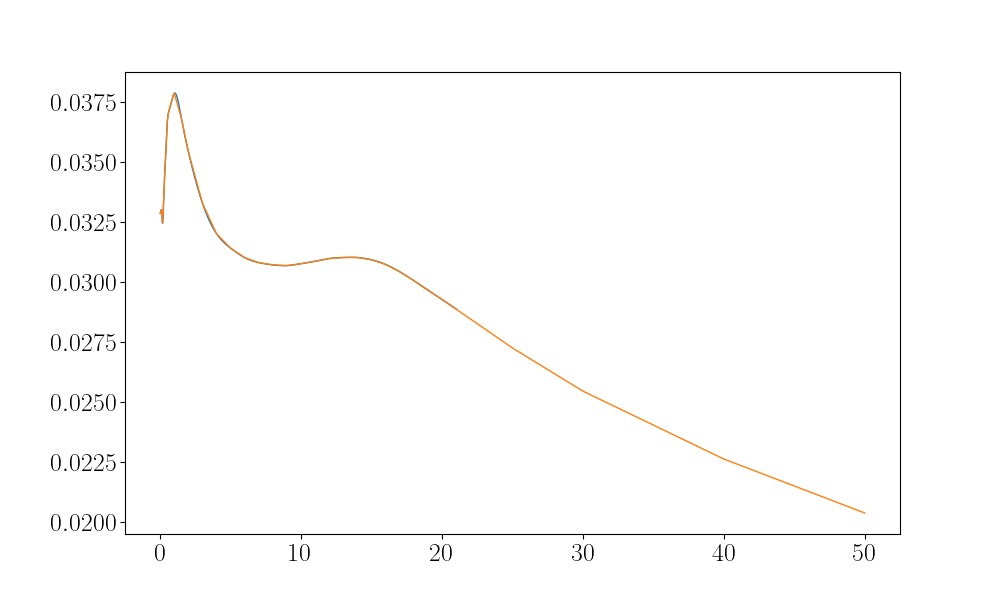

In [67]:
display(np.array(hist_zerorates)[t_cplt_index,:])
fig=plt.figure()
plt.plot(daily_tenor_data_cplt/365,zr_data_cplt)
plt.plot(tenors_in_years, np.array(hist_zerorates)[t_cplt_index,:])

0

7664

7663

<IPython.core.display.Javascript object>


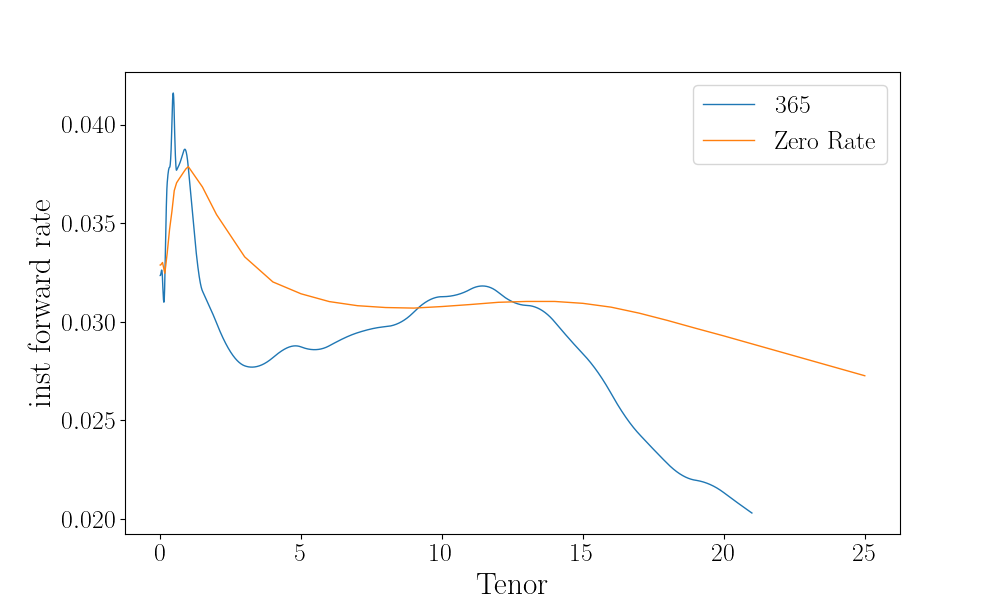

In [68]:
display(len(fwr_cplt_data_252), len(daily_tenor_data_cplt), len(fwr_cplt_data_365))
fig = plt.figure()
#plt.plot(daily_tenor_data_cplt[0:-1]/365, fwr_cplt_data_252,label='252')
plt.plot(daily_tenor_data_cplt[0:-1]/365, fwr_cplt_data_365,label='365')
plt.plot(tenors_in_years[0:35], np.array(hist_zerorates)[t_cplt_index,0:35],label='Zero Rate')
plt.xlabel('Tenor')
plt.ylabel('inst forward rate')
plt.legend()

We now want to calibrate the "Black-Scholes" ZCB Option price to the "Discounted Flow" by varying the volatility parameter.

In [69]:
def P_fwr_cplt(t,T):
    index_T = list(daily_tenor_data_cplt).index(T)
    
    #print(len(fwr_data[0:index_T]), len(daily_tenor[0:index_T]))
    exponent = -integrate.simps(fwr_cplt_data[0:index_T+1], 
                                daily_tenor_data_cplt[0:index_T+1]/365, dx=0.1)
    return np.exp(exponent)

def d_fwr_HJM_cplt(t0, theta1, theta2, K, sign, vol):
    
    nominator = np.log(P_fwr_cplt(t0,theta2)/(K*P_fwr_cplt(t0,theta1))) + (-1)**sign*1/2*vol**2*((theta2-theta1)/365)**2*theta1/365
    denominator = vol*((theta2-theta1)/365)*np.sqrt(theta1/365)
    
    return nominator/denominator

def C_fwr_HJM_cplt(t0,theta1,theta2,K, vol):
    
    return P_fwr_cplt(t0,theta2)*norm.cdf(d_fwr_HJM_cplt(t0,theta1,theta2,K,0, vol))-K*P_fwr_cplt(t0,theta1)*norm.cdf(d_fwr_HJM_cplt(t0,theta1,theta2,K,1, vol))

def P_fwr_HJM_cplt(t0, theta1, theta2, K, vol):
    return -P_fwr_cplt(t0,theta2)*norm.cdf(-d_fwr_HJM_cplt(t0,theta1,theta2,K,0, vol))+K*P_fwr_cplt(t0,theta1)*norm.cdf(-d_fwr_HJM_cplt(t0,theta1,theta2,K,1, vol))


#t_cplt = 10/04/2023
#theta1 = time between 't_cplt' and 'fixing date'
#theta2 = time between 't_cplt' and 'payment date'

def cplt_res_hjm(vol, t0, theta1, theta2, K):
    #print('Model price: ',C_fwr_HJM_cplt(t0, theta1, theta2, K, vol),
    #      'Market price: ', caplet_flow[-1]/(1e8))
    K_cplt = 1/(1+caplet_strikes[2]*caplet_date_delta[2])
    return (((1+caplet_date_delta[2]*caplet_strikes[2])*P_fwr_HJM_cplt(t0, theta1, theta2, K_cplt, vol)[0]-caplet_flow[2]/(1e8))/(caplet_flow[2]/(1e8)))**2



#--------------------Field Theory---------------------------

def q_fwr(t_0, theta_1, theta_2, mu, vol):
        
    t0 = t_0/365
    theta1 = theta_1/365
    theta2 = theta_2/365
    
    def integrand(t, theta_11, theta_12):
        return vol*D_theta(theta_11,theta_12, mu)*vol
    
    integral = tplquad(integrand, t0, theta1+t0, theta1, theta2, theta1, theta2)
    
    return np.sqrt(integral[0])

def q_fwr_TFR(t_0, theta_1, theta_2, mu, vol):
        
    t0 = t_0/365
    theta1 = theta_1/365
    theta2 = theta_2/365
    
    def integrand(t, theta_11, theta_12):
        return vol(theta_11)*D_TFR_norm(theta_11,theta_12, max_tenor+30, mu)*vol
    
    integral = tplquad(integrand, t0, theta1+t0, theta1, theta2, theta1, theta2)
    
    return np.sqrt(integral[0])

def d_fwr_FT_cplt(q,t0, theta1, theta2, mu, sign, K):
    
    #q = q_fwr(t0, theta1, theta2, mu)
    
    d = 1/q*(np.log(P_fwr_cplt(t0,theta2)/(K*P_fwr_cplt(t0,theta1))) + q**2/2)
    
    if sign == 0:  
        return d
    else:
        return d-q

def C_fwr_FT_cplt(t0, theta1, theta2, mu, K, vol):
    
    q = q_fwr(t0, theta1, theta2, mu, vol)
    
    d = d_fwr_FT_cplt(q, t0, theta1, theta2, mu, 0, K)
    
    return P_fwr_cplt(t0, theta2)*norm.cdf(d) - K*P_fwr_cplt(t0, theta1)*norm.cdf(d-q)

def C_fwr_TFR_FT_cplt(t0, theta1, theta2, mu, K, vol):
    
    q = q_fwr_TFR_cplt(t0, theta1, theta2, mu, vol)
    
    d = d_fwr_FT_cplt(q, t0, theta1, theta2, mu, 0, K)
    
    return P_fwr_cplt(t0, theta2)*norm.cdf(d) - K*P_fwr_cplt(t0, theta1)*norm.cdf(d-q)

def P_fwr_FT_cplt(t0, theta1, theta2, mu, K, vol):
    
    q = q_fwr(t0, theta1, theta2, mu, vol)
    
    d = d_fwr_FT_cplt(q, t0, theta1, theta2, mu, 0, K)
    
    return -P_fwr_cplt(t0, theta2)*norm.cdf(-d) + K*P_fwr_cplt(t0, theta1)*norm.cdf(-d+q)

def cplt_res_ft(x, t0, theta1, theta2, K):
    v, mu = x
    K_cplt = 1/(1+caplet_strikes[2]*caplet_date_delta[2])
    res = (((1+caplet_date_delta[2]*caplet_strikes[2])*P_fwr_FT_cplt(t0, theta1, theta2, mu, K_cplt, v)-caplet_flow[2]/(1e8))/(caplet_flow[2]/(1e8)))**2
    return res

<IPython.core.display.Javascript object>


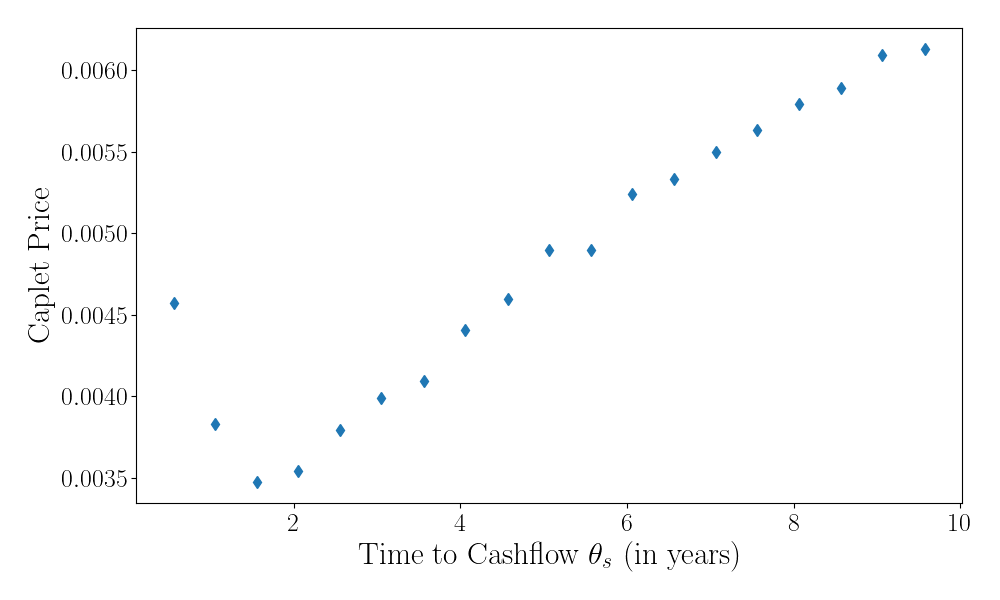

In [100]:
caplet_prices = [caplet_flow[i]/(1e8) for i in range(1, len(caplet_flow))]
caplet_times_to_expiry = np.array([caplet_time_to_fixing[i] for i in range(1, len(caplet_time_to_fixing))])/365
fig = plt.figure()
plt.plot(caplet_times_to_expiry, caplet_prices, 'd')
plt.xlabel(r'Time to Cashflow $\theta_s$ (in years)')
plt.ylabel('Caplet Price')
plt.tight_layout()
plt.savefig('caplet_market_prices', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

In [72]:
#We neglect the two first data entries
def caplet_rmse_hjm(v):
    K_cplt = [1/(1+caplet_date_delta[i]*caplet_strikes[i]) for i in range(3,len(caplet_strikes))]
    #print(len(K_cplt))
    Put_cplt = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_HJM_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                  caplet_time_to_payment[i],K_cplt[i-3], v)
              for i in range(3,len(caplet_strikes))]
    #print(Put_cplt)
    #print('prices: ',Put_cplt)
    cplt_mse = sum([((caplet_flow[i]/(1e8)-Put_cplt[i-3])/(caplet_flow[i]/1e8))**2 for i in range(3,len(caplet_strikes))])/len(caplet_strikes[3:])
    #print('MSE HJM: ', cplt_mse)
    #print('RMSE HJM: ', np.sqrt(cplt_mse))
    return np.sqrt(cplt_mse)

def caplet_rmse_ft(x):
    v, mu = x
    K_cplt = [1/(1+caplet_date_delta[i]*caplet_strikes[i]) for i in range(3,len(caplet_strikes))]
    #print(len(K_cplt))
    P_cplt = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_FT_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                  caplet_time_to_payment[i], mu, K_cplt[i-3], v)
              for i in range(3,len(caplet_strikes))]
    #print(P_cplt)
    cplt_mse = sum([((caplet_flow[i]/(1e8)-P_cplt[i-3])/(caplet_flow[i]/1e8))**2 for i in range(3,len(caplet_strikes))])/len(caplet_strikes[3:])
    print('RMSE FT: ',np.sqrt(cplt_mse))
    return np.sqrt(cplt_mse)

In [73]:
hjm_cplt_min = minimize(caplet_rmse_hjm, x0 = 0.02, method = 'Nelder-Mead')
display(hjm_cplt_min)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.029811623305165274
             x: [ 1.269e-02]
           nit: 10
          nfev: 20
 final_simplex: (array([[ 1.269e-02],
                       [ 1.266e-02]]), array([ 2.981e-02,  2.986e-02]))

<IPython.core.display.Javascript object>


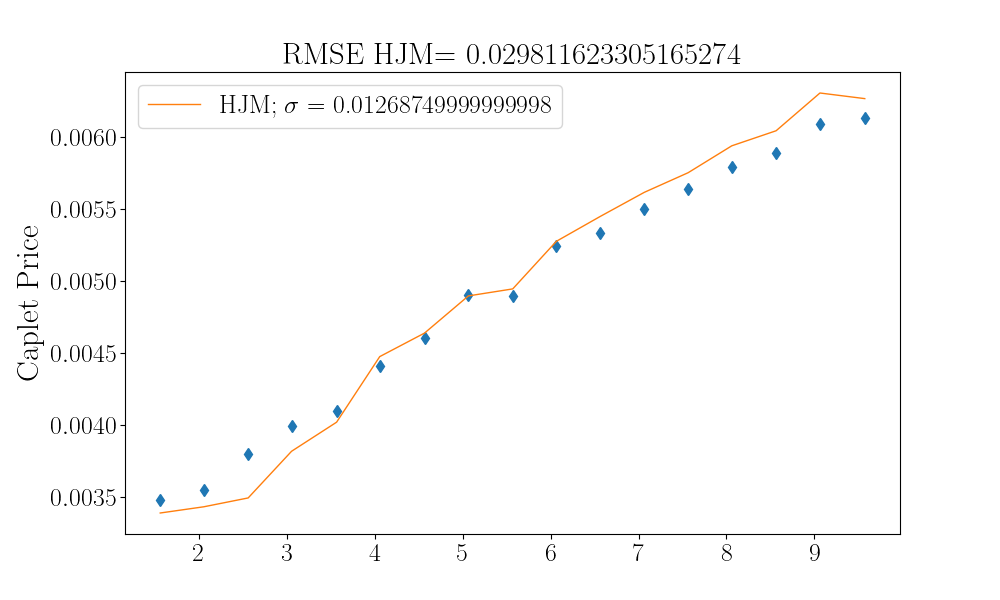

In [74]:
K_cplt = [1/(1+caplet_date_delta[i]*caplet_strikes[i]) for i in range(3,len(caplet_strikes))]
hjm_caplet_prices = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_HJM_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                  caplet_time_to_payment[i], K_cplt[i-3], hjm_cplt_min.x[0])
              for i in range(3,len(caplet_strikes))]
#hjm_test_price = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_HJM_cplt(t_cplt, caplet_time_to_fixing[i],
#                                                                                  caplet_time_to_payment[i], K_cplt[i-3], 0.0239375/1.5)
#              for i in range(3,len(caplet_strikes))]

fig = plt.figure()
plt.plot(caplet_times_to_expiry[2:], caplet_prices[2:], 'd')
plt.plot(caplet_times_to_expiry[2:], hjm_caplet_prices, label='HJM; $\sigma=$ '+str(hjm_cplt_min.x[0]))
#plt.plot(caplet_times_to_expiry[2:], hjm_test_price, label ='test curve')
#plt.xlabel('Time to Expiry (in years)')
plt.ylabel('Caplet Price')
plt.title('RMSE HJM= '+str(hjm_cplt_min.fun))
plt.legend()
plt.show()

In [75]:

start = time.time()
ft_caplet_min = minimize(caplet_rmse_ft, x0=[0.07,0.04], method='Nelder-Mead', options={'maxiter':200, 'maxfev':100})
end = time.time()
duration = end-start
display(ft_caplet_min, duration)

RMSE FT:  4.33937247146789
RMSE FT:  4.606326727731239
RMSE FT:  4.32890362079206
RMSE FT:  4.062450732919313
RMSE FT:  3.7912397638119653
RMSE FT:  3.7817104293452273
RMSE FT:  3.5046717951269275
RMSE FT:  2.9705304363685117
RMSE FT:  2.297502580112397
RMSE FT:  2.0193967907951396
RMSE FT:  1.1503556400175983
RMSE FT:  0.033176158653970875
RMSE FT:  0.26400489419464634
RMSE FT:  0.869537819639595
RMSE FT:  0.2752617243874856
RMSE FT:  0.8057391645757608
RMSE FT:  0.8218997049207567
RMSE FT:  0.8379351179786785
RMSE FT:  0.5821373192283119
RMSE FT:  0.5598754436328158
RMSE FT:  1.1255153029726646
RMSE FT:  0.16104095375882194
RMSE FT:  0.7420579016428223
RMSE FT:  0.2327374761042706
RMSE FT:  0.419530983127815
RMSE FT:  0.07096637059504801
RMSE FT:  0.20221460382707931
RMSE FT:  0.07217551743057322
RMSE FT:  0.11212870667123029
RMSE FT:  0.03044216133887428
RMSE FT:  0.12309937131111522
RMSE FT:  0.027419707598392618
RMSE FT:  0.030087396635922133
RMSE FT:  0.07256034519377577
RMSE FT:

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.016929181207162358
             x: [ 1.339e-02  5.898e-02]
           nit: 42
          nfev: 81
 final_simplex: (array([[ 1.339e-02,  5.898e-02],
                       [ 1.339e-02,  5.888e-02],
                       [ 1.339e-02,  5.894e-02]]), array([ 1.693e-02,  1.693e-02,  1.693e-02]))

188.99452090263367

In [76]:
start = time.time()
ft_caplet_lsq = least_squares(caplet_rmse_ft, x0=[ft_caplet_min.x[0], ft_caplet_min.x[1]], bounds=([0,-np.inf],[1,np.inf]), ftol=1e-4)
end = time.time()
durartion = end-start
display(ft_caplet_lsq, duration)

RMSE FT:  0.016929181207162358
RMSE FT:  0.01692918022233892
RMSE FT:  0.016929181226923665
RMSE FT:  4.5040132294603605
RMSE FT:  1.1249863021391477
RMSE FT:  0.2815901967372567
RMSE FT:  0.07225812513879971
RMSE FT:  0.024383878481487254
RMSE FT:  0.01748550924508866
RMSE FT:  0.016963733102236953
RMSE FT:  0.016931154177155502
RMSE FT:  0.016929257372590427
RMSE FT:  0.016929174179470104
RMSE FT:  0.016929174324327875
RMSE FT:  0.016929174183240185


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.693e-02]
           x: [ 1.339e-02  5.898e-02]
        cost: 0.00014329846919941864
         jac: [[ 9.721e-03  2.530e-04]]
        grad: [ 1.646e-04  4.283e-06]
  optimality: 4.28318068861718e-06
 active_mask: [0 0]
        nfev: 11
        njev: 2

188.99452090263367

In [77]:
K_cplt = [1/(1+caplet_date_delta[i]*caplet_strikes[i]) for i in range(3,len(caplet_strikes))]

ft_caplet_prices = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_FT_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                             caplet_time_to_payment[i], 
                                                                             ft_caplet_min.x[1], K_cplt[i-3], ft_caplet_min.x[0])
                    for i in range(3, len(caplet_strikes))]

In [78]:
hjm_caplet_prices = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_HJM_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                  caplet_time_to_payment[i], K_cplt[i-3], hjm_cplt_min.x[0])
                     for i in range(3,len(caplet_strikes))]

In [79]:
ft_caplet_prices_lsq =[(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_FT_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                caplet_time_to_payment[i], 
                                                                                ft_caplet_lsq.x[1], K_cplt[i-3], ft_caplet_lsq.x[0])
                    for i in range(3, len(caplet_strikes))]

We now want to implement a more "fair" model comparison by including the ZCB option price in a Hull-White setting, i.e. we take the volatility $\sigma(t,s)$ equal to

$$\sigma(t,s)=ve^{-a(s-t)},$$

where $v,a$ are the parameters to be calibrated. Note that we will not use this vol function in a Field Theory formalism, so no propagator $D(\theta,\theta';t_0)$ 

This means that the "effective volatility" $q$ is given as, for $\theta=s-t

$$q^2=\int_{t_0}^{t_0+\theta_*}dt\left[\int_{t_*-t}^{T-t}d\theta\sigma(t,\theta)\right]^2$$
$$=v^2\int_{t_0}^{t_0+\theta_*}dt\left[\int_{t_*-t}^{T-t}d\theta e^{-a\theta}\right]^2$$
$$=v^2\int_{t_0}^{t_0+\theta_*}\left[\frac{e^{-a(t_*-t)}-e^{-a(T-t)}}{a}\right]^2$$
$$=\frac{v^2}{a^2}\int_{t_0}^{t_0+\theta_*}\left[e^{-2a(t_*-t)}-2e^{-a(t_*+T-2t)}+e^{-2a(T-t)}\right]$$
$$=\frac{v^2}{a^2}\left[e^{-2at_*}-2e^{-2a(T+t_*)}+e^{-2aT}\right]\int_{t_0}^{t_0+\theta_*}dte^{2at}$$
$$=\frac{v^2}{2a^3}\left(e^{-at_*}-e^{-aT}\right)^2\left(e^{2a(t_0+\theta_*)}-e^{2at_0}\right) $$
$$=\frac{v^2}{2a^3}\left(e^{-a\theta_*}-e^{-a\theta_0}\right)^2\left(e^{a\theta_*}-1\right)$$

where $\theta_0\equiv T-t_0$ and $\theta_*\equiv t_*-t_0$

In [80]:
def vol_hw(v,a,theta):
    return v*np.exp(-a*theta/365)

def q_hw(v,a,theta_1, theta_2):
    
    theta1 = theta_1/365
    theta2 = theta_2/365
    
    return np.sqrt(v**2/(2*a**3)*((np.exp(-a*theta1)-np.exp(-a*theta2))**2*(np.exp(a*theta1)-1)))

def d_hw(q, t0, theta1, theta2, K, sign):
    
    d = 1/q*(np.log(P_fwr_cplt(t0,theta2)/(K*P_fwr_cplt(t0,theta1)))+q**2/2)
    
    if sign == 0:  
            return d
    else:
            return d-q
        
def P_fwr_hw_cplt(t0, theta1, theta2, K, v, a):
    
    q = q_hw(v,a,theta1,theta2)
    d = d_hw(q, t0, theta1, theta2, K, 0)
    
    return -P_fwr_cplt(t0, theta2)*norm.cdf(-d) + K*P_fwr_cplt(t0, theta1)*norm.cdf(-d+q)

In [81]:
def caplet_rmse_hw(x):
    v, a = x
    K_cplt = [1/(1+caplet_date_delta[i]*caplet_strikes[i]) for i in range(3,len(caplet_strikes))]
    P_cplt = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_hw_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                  caplet_time_to_payment[i], K_cplt[i-3], v, a)
              for i in range(3,len(caplet_strikes))]
    cplt_mse = sum([((caplet_flow[i]/(1e8)-P_cplt[i-3])/(caplet_flow[i]/1e8))**2 for i in range(3,len(caplet_strikes))])/len(caplet_strikes[3:])
    #print('RMSE HW: ',np.sqrt(cplt_mse))
    return np.sqrt(cplt_mse)

In [82]:
start = time.time()
x_0 = [0.07,0.04]
for i in range(0,5):
    hw_caplet_min_lsq = least_squares(caplet_rmse_hw, x0=[x_0[0],x_0[1]], bounds=([0,0],[1,np.inf]))
    x_0 = [hw_caplet_min_lsq.x[0],hw_caplet_min_lsq.x[1]]
    print(i)
end = time.time()
duration = end-start
display(hw_caplet_min_lsq, duration)

0
1
2
3
4


     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 1.661e-02]
           x: [ 1.917e-02  1.527e-02]
        cost: 0.00013791077770615166
         jac: [[ 5.524e-02  2.337e-01]]
        grad: [ 9.175e-04  3.881e-03]
  optimality: 5.924662545270101e-05
 active_mask: [0 0]
        nfev: 200
        njev: 145

198.0729420185089

In [84]:
start = time.time()
x_0 = [0.07,0.04]
for i in range(0,10):
    #hw_caplet_min = minimize(caplet_rmse_hw, x0=[x_0[0],x_0[1]], method='Powell', bounds=((0,1), (None,None)), options={'maxiter':200, 'maxfev':150})
    hw_caplet_min = minimize(caplet_rmse_hw, x0=[x_0[0],x_0[1]], method='Nelder-Mead', options={'maxiter':200, 'maxfev':250})
    x_0=[hw_caplet_min.x[0],hw_caplet_min.x[1]]
    print(i)
    
end = time.time()
duration = end-start
display(hw_caplet_min, duration)

0
1
2
3
4
5
6
7
8
9


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.016456111355678798
             x: [ 1.907e-02  1.399e-02]
           nit: 11
          nfev: 23
 final_simplex: (array([[ 1.907e-02,  1.399e-02],
                       [ 1.906e-02,  1.389e-02],
                       [ 1.908e-02,  1.400e-02]]), array([ 1.646e-02,  1.646e-02,  1.646e-02]))

21.491632223129272

In [85]:
a_min = hw_caplet_min.x[1]
v_min = hw_caplet_min.x[0]
a_lsq = hw_caplet_min_lsq.x[1]
v_lsq = hw_caplet_min_lsq.x[0]

hw_caplet_prices_min = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_hw_cplt(t_cplt, caplet_time_to_fixing[i],caplet_time_to_payment[i], K_cplt[i-3], v_min, a_min) for i in range(3, len(caplet_strikes))]
hw_caplet_prices_lsq = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_hw_cplt(t_cplt, caplet_time_to_fixing[i],caplet_time_to_payment[i], K_cplt[i-3], v_lsq, a_lsq) for i in range(3, len(caplet_strikes))]

In [86]:
ft_test_cap = [(1+caplet_strikes[i]*caplet_date_delta[i])*P_fwr_FT_cplt(t_cplt, caplet_time_to_fixing[i],
                                                                                caplet_time_to_payment[i], 
                                                                                1e-7, K_cplt[i-3], hjm_cplt_min.x[0])
                    for i in range(3, len(caplet_strikes))]

<IPython.core.display.Javascript object>


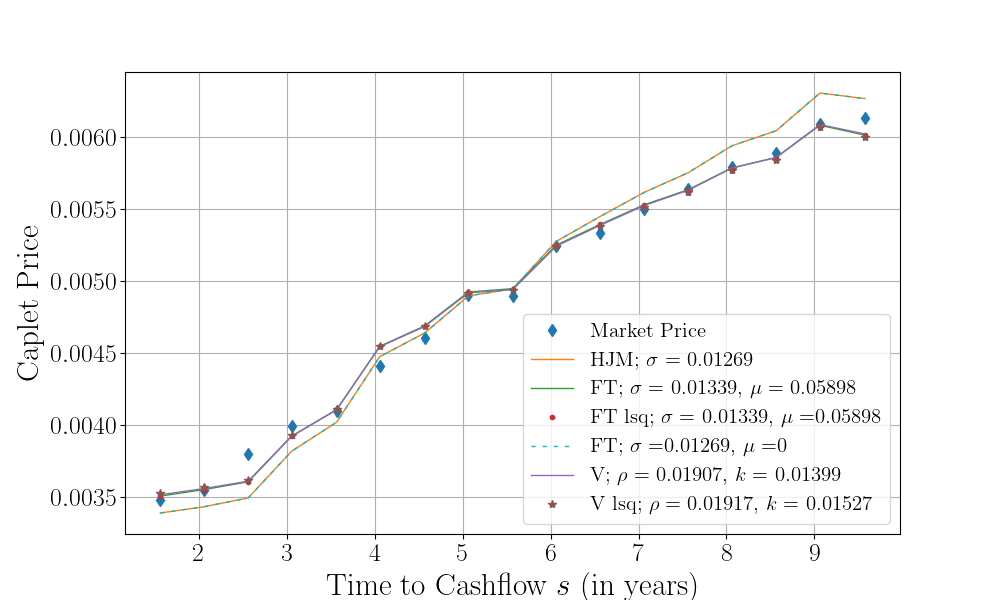

In [92]:
fig = plt.figure()
plt.plot(caplet_times_to_expiry[2:], caplet_prices[2:], 'd', label='Market Price')
#plt.plot(caplet_times_to_expiry[2:], ft_test_price)
plt.plot(caplet_times_to_expiry[2:], hjm_caplet_prices, label='HJM; $\sigma= $ '+str("%.5f" % hjm_cplt_min.x[0]))
plt.plot(caplet_times_to_expiry[2:], ft_caplet_prices, label='FT; $\sigma= $ '+str("%.5f" % ft_caplet_min.x[0])+', $\mu=$ '+str("%.5f" % ft_caplet_min.x[1]))
plt.plot(caplet_times_to_expiry[2:], ft_caplet_prices_lsq, '.', label='FT lsq; $\sigma=$ '+str("%.5f" % ft_caplet_lsq.x[0])+", $\mu= $"+str("%.5f" % ft_caplet_lsq.x[1]))
plt.plot(caplet_times_to_expiry[2:], ft_test_cap, '--',dashes=(3,5), color='c', label='FT; $\sigma= $'+str("%.5f" % hjm_cplt_min.x[0])+', $\mu= $'+str(0))
plt.plot(caplet_times_to_expiry[2:], hw_caplet_prices_min, label=r'V; $\rho=$ '+str("%.5f" % v_min)+', $k=$ '+str("%.5f" % a_min))
plt.plot(caplet_times_to_expiry[2:], hw_caplet_prices_lsq, '*',label=r'V lsq; $\rho=$ '+str("%.5f" % v_lsq)+', $k=$ '+str("%.5f" % a_lsq))
plt.xlabel('Time to Cashflow $s$ (in years)')
plt.ylabel('Caplet Price')
#plt.suptitle(r'Calibration Results')
#plt.title(r'$RMSE_{HJM}= $'+str("%.5f" % hjm_cplt_min.fun)+'; $RMSE_{FT}=$ '+str("%.5f" % ft_caplet_min.fun)+'; $RMSE_{HW}=$ '+str("%.5f" % hw_caplet_min.fun),
#          fontsize = 12)
legend = plt.legend(loc="lower right",fontsize=15)
for t in legend.get_texts():
    t.set_ha('left')
plt.grid(True)
plt.savefig('Caplet_Prices_Models_vs_Market_clean', bbox_inches='tight', pad_inches=0.01, dpi=400)
plt.show()

Note that the H-W result and Field Theory result more similar than HJM. However, the Field Theory result is still a lot more accurate and can also be agrued to be at a disadvantage as we are comparing the Field Theory with constant vol to H-W with non-constant vol. A more "fair" comparison would be if we set the Field Theory vol equal to $\sigma_{FT}(t,\theta)=ve^{-a\theta}$ and then calculate $q$ as

$$q^2=\int_{t_0}^{t_*}dt\int_{t_*}^{T}d\theta d\theta'\sigma(t,\theta)D(\theta,\theta';t)\sigma(t,\theta')$$